<a href="https://colab.research.google.com/github/DavidSenseman/BIO1173/blob/main/Class_02_3_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---------------------------
**COPYRIGHT NOTICE:** This Jupyterlab Notebook is a Derivative work of [Jeff Heaton](https://github.com/jeffheaton) licensed under the Apache License, Version 2.0 (the "License"); You may not use this file except in compliance with the License. You may obtain a copy of the License at

> [http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

------------------------

# **BIO 1173: Intro Computational Biology**

##### **Module 2: Neural Networks with PyTorch**

* Instructor: [David Senseman](mailto:David.Senseman@utsa.edu), [Department of Biology, Health and the Environment](https://sciences.utsa.edu/bhe/), [UTSA](https://www.utsa.edu/)

### Module 2 Material

* Part 2.1: Introduction to Neural Networks with PyTorch
* Part 2.2: Encoding Feature Vectors
* **Part 2.3: Controlling Overfitting**
* Part 2.4: Saving and Loading a PyTorch Neural Network

## Google CoLab Instructions

You MUST run the following code cell to get credit for this class lesson. By running this code cell, you will map your GDrive to /content/drive and print out your Google GMAIL address. Your Instructor will use your GMAIL address to verify the author of this class lesson.

In [ ]:
# @title You must run this cell first!
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    from google.colab import auth
    auth.authenticate_user()
    Colab = True
    print("Note: Using Google Colab")
    import requests
    gcloud_token = !gcloud auth print-access-token
    gcloud_tokeninfo = requests.get('https://www.googleapis.com/oauth2/v3/tokeninfo?access_token=' + gcloud_token[0]).json()
    print(gcloud_tokeninfo['email'])
except:
    print("**WARNING**: Your GMAIL address was **not** printed in the output below.")
    print("**WARNING**: You will NOT receive credit for this lesson.")
    Colab = False

Mounted at /content/drive
Note: Using Google Colab
david.senseman@gmail.com


You should see the following output except your GMAIL address should appear on the last line.
```text
Mounted at /content/drive
Note: Using Google Colab
studentbio1173@gmail.com
```
Make sure you GMAIL is visible or you will lose 20 pts on your submission.

### Create Functions

Run the cell below to create a function that will be needed later in this lesson.

In [ ]:
# @title Create Functions

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

def set_seeds(seed_value):
    """
    Sets the seed for reproducibility across Python, NumPy, and PyTorch.
    """
    import random

    # 1. Base Python
    random.seed(seed_value)

    # 2. NumPy
    np.random.seed(seed_value)

    # 3. PyTorch (CPU and CUDA)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # For multi-GPU setups

    # 4. CuDNN Determinism (Crucial for GPU consistency)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # 5. Optional: Ensure all operations are deterministic
    # Note: Some specialized operations might throw an error if no
    # deterministic implementation exists.
    # torch.use_deterministic_algorithms(True)

    print(f"✅ Seeds set to: {seed_value}")

print("Functions for this lesson have been created successfully.")

Functions for this lesson have been created successfully.


If the code is correct you should see the following output:
```text
Functions for this lesson have been created successfully.
```

## **Data Sets for this Lesson**

For this lesson, the **Obesity Data Set** will be used for the Examples and the **Heart Disease Data Set** will be used for the **Exercises**. Information about the Heart Disease Data set was presented in the previous lesson. Here is the information about the Obesity Data set.

### **Obesity Data Set**

![___](https://biologicslab.co/BIO1173/images/obesity.jpg)

[Obesity Data Set](https://archive.ics.uci.edu/ml/datasets/)

**Description:**

The **Obesity Data Set** includes data for the estimation of obesity levels in individuals from the countries of Mexico, Peru and Colombia, based on their eating habits and physical condition. The data contains 17 attributes and 2111 records, the records are labeled with the class variable NObesity (Obesity Level), that allows classification of the data using the values of `Insufficient Weight`, `Normal Weight`, `Overweight Level I`, `Overweight Level II`, `Obesity Type I`, `Obesity Type II` and `Obesity Type III`.

**Key Features:**

* **Gender-** Female/Male
* **Age-** Numeric value
* **Height-** Numeric value in meters
* **Weight-** Numeric value in kilograms
* **family_history_with_overweight-** Has a family member suffered or suffers from overweight - Yes/No
* **FAVC-** Do you eat high caloric food frequently - Yes/No
* **FCVC-** Do you usually eat vegetables in your meals - Never/Sometimes/Always
* **NCP-** How many main meals do you have daily - Between 1 y 2/Three/More than three
* **CAEC-** Do you eat any food between meals? - No/Sometimes/Frequently/Always
* **SMOKE-** Do you smoke? - Yes/No
* **CH2O-** How much water do you drink daily? - Less than a liter/Between 1 and 2 L/More than 2 L
* **SCC-** Do you monitor the calories you eat daily - Yes/No
* **FAF-** How often do you have physical activity? - I do not have/1 or 2 days/2 or 4 days/4 or 5 days
* **TUE-** How much time do you use technological devices such as cell phone, videogames, television, computer and others - 0–2 hours/3–5 hours/More than 5 hours
* **CALC-** How often do you drink alcohol? - I do not drink/Sometimes/Frequently/Always
* **MTRANS-** Which transportation do you usually use? Automobile/Motorbike/Bike/Public Transportation/Walking
* **NObeyesdad-** Obesity levels: 'Insufficient_Weight', 'Obesity_Type_III', 'Normal_Weight', 'Obesity_Type_II', 'Overweight_Level_I', 'Obesity_Type_I', 'Overweight_Level_II'

For our classification neural network (`eg_model`), the response variable (`Y`) will be the column `NObeyesdad`. This column contains 7 categorical variables shown here sorted from lowest to highest obesity:

* Insufficient_Weight
* Normal_Weight
* Overweight_Level_I
* Overweight_Level_II
* Obesity_Type_I  
* Obesity_Type_II
* Obesity_Type_III


----------------------------------------------

# **The Problem of `Overfitting`**

When a neural network learns a task, it adjusts its parameters so that the error on the training data decreases.

However, it can be quite easy for the model to becomes **too good** at reproducing the training sample by **memorizing idiosyncratic noise** instead of capturing the true underlying relationship. This situation is called **overfitting**.

#### **How `Overfitting` Happens**

* **Too many trainable parameters:**
A very deep or wide network can represent a vast space of functions.
With few training examples, the model can fit every detail, including random fluctuations.

* **Insufficient or unrepresentative data:**
If the training set does not cover the variability of the problem domain, the model learns patterns that only exist in the training data.

* **Training for too many epochs:**
Continuing the optimisation past the point where validation error stops decreasing lets the network fine‑tune to noise.

* **Lack of regularisation:**
No constraints on weights, activations or hidden‑layer outputs allow the model to swing wildly to minimise the training loss.

#### **Why `Overfitting` is Bad**

* **Poor generalisation:**
The model's predictions on new data (test set, real-world inputs) are much worse than its performance on the training set.

* **Misleading confidence:**
An overfitted network often reports low loss or high accuracy, giving a false sense of reliability.

* **Wasted resources:**
Training longer or with more complex architectures is unnecessary when the model will not perform better on unseen data.

* **Deployment risks:**
In safety-critical applications (self-driving cars, medical diagnosis), an overfitted model can produce dangerous errors.

## **Controlling `Overfitting`**

This lesson focuses on how you can control overfitting during the training of neural networks. Here are the 4 common strategies that are typically used in PyTorch to deal with the issues related to overfitting:


* **`L2 Regularization`**
* **`Dropout` Layers**
* **`Batch Processing`**
* **`Early Stopping`**

To illustrate the strengths and weaknesses of each strategy, this lesson will use four Examples and four companion **Exercises**.

1. `Example 1`/**`Exercise 1`**: A classification neural network will be trained _without_ any measures to prevent overfitting. This will serve as a **baseline** against which to judge the remaining Examples and **Exercises**.
2. `Example 2`/**`Exercise 2`**: Exactly the same neural network will be trained using **`L2 Regularization`** to control overfitting.
3. `Example 3`/**`Exercise 3`**: Instead of L2 Regularization, the technique of **`Dropout Layers`** will be used to limit overfitting.
4. `Example 4`/**`Exercise 4`**: The technique of **`Batch Processing`** will be used to limit overfitting.
4. `Example 5`/**`Exercise 5`**: Finally, the technique of adding **`Early Stopping`** will be used to limit overfitting.

It should be noted that there is no technical reason to limit yourself to a single technique to limit overfitting -- two (or more) strategies are often used in combination depending upon the particular situation.

### Example 1A: No Overfitting Prevention

In earlier lessons the training of neural networks was divided into a series of smaller steps to help students master the underlying programming concepts. The code in the cell below, however, provides a all the code in a single block that is needed to:
1. Read and preparing the tabular data
2. Build and compile a classification neural network using PyTorch
3. Train the neural network.
4. Visualize the training.

While a detailed explanation of the different code chucks will not be provided, here are a few key points.

1. The following code chunk reads the `Obesity Data Set` from the course web server and stores it in a DataFrame called `eg_df`.
```text
# ------------------------------------------------------------
# 2️⃣  Load data
# ------------------------------------------------------------
eg_df = pd.read_csv("https://biologicslab.co/BIO1173/data/ObesityDataSet.csv",
                    na_values=['NA','?'])

```
You will of course have to modify this line of code to read the Heart Disease data set for **`Exercise 1`**.

You should note that the variable **`VERSBOSE`** has been set to `0`. This means there will be no output during training. This has been done to help keep the length of you Colab PDF a more reasonable value. However, in the last example/exercise pair, the verbose variable is set to `2` to print out the values generated during training.

In [ ]:
# Example 1A: No Overfitting Prevention

# ------------------------------------------------------------
# 0️⃣  Imports
# ------------------------------------------------------------
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ------------------------------------------------------------
# 1️⃣  Parameters
# ------------------------------------------------------------
EPOCHS        = 100
PATIENCE      = 10
VERBOSE       = 0     # 0 means no output during training
LEARNING_RATE = 0.05
BATCH_SIZE    = 32

# Print title
print("Example 1A: No Overfitting Prevention")

# Set Seed
seed_value = 42
set_seeds(seed_value)

# Set device to CPU
device = torch.device("cpu")
print(f"Using device: {device}")

# ------------------------------------------------------------
# 2️⃣  Load data
# ------------------------------------------------------------
eg_df = pd.read_csv("https://biologicslab.co/BIO1173/data/ObesityDataSet.csv",
                    na_values=['NA','?'])

# ------------------------------------------------------------
# 3️⃣  Target (Y-values)
# ------------------------------------------------------------
eg_target_col = "NObeyesdad"
le = LabelEncoder()
eg_df[eg_target_col] = le.fit_transform(eg_df[eg_target_col])

eg_X = eg_df.drop(columns=[eg_target_col])
eg_y = eg_df[eg_target_col].astype('int32')

# ------------------------------------------------------------
# 4️⃣  Train–Validation–Test Split
# ------------------------------------------------------------
# First split into train+val and test
eg_X_temp, eg_X_test, eg_y_temp, eg_y_test = train_test_split(
    eg_X, eg_y, test_size=0.2, random_state=42, stratify=eg_y)

# Then split train+val into train and val
eg_X_train, eg_X_val, eg_y_train, eg_y_val = train_test_split(
    eg_X_temp, eg_y_temp, test_size=0.1, random_state=42, stratify=eg_y_temp)

# ------------------------------------------------------------
# 5️⃣  Preprocessing
# ------------------------------------------------------------
categorical_cols = [c for c in eg_X.columns if eg_X[c].dtype == "object"]
numeric_cols     = [c for c in eg_X.columns if c not in categorical_cols]

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler",  StandardScaler())
    ]), numeric_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(drop="if_binary", sparse_output=False))
    ]), categorical_cols)
])

# Convert data to correct numeric type (Numpy arrays)
eg_X_train_proc = preprocessor.fit_transform(eg_X_train).astype(np.float32)
eg_X_val_proc   = preprocessor.transform(eg_X_val).astype(np.float32)
eg_X_test_proc  = preprocessor.transform(eg_X_test).astype(np.float32)

eg_y_train = eg_y_train.to_numpy().astype(np.int32).reshape(-1)
eg_y_val   = eg_y_val.to_numpy().astype(np.int32).reshape(-1)
eg_y_test  = eg_y_test.to_numpy().astype(np.int32).reshape(-1)

# ------------------------------------------------------------
# 6️⃣  Convert to PyTorch Tensors & DataLoaders
# ------------------------------------------------------------
# Convert Features to Float Tensors
eg_X_train_t = torch.tensor(eg_X_train_proc).to(device)
eg_X_val_t   = torch.tensor(eg_X_val_proc).to(device)
eg_X_test_t  = torch.tensor(eg_X_test_proc).to(device)

# Convert Targets to Long Tensors (Required for CrossEntropyLoss)
eg_y_train_t = torch.tensor(eg_y_train, dtype=torch.long).to(device)
eg_y_val_t   = torch.tensor(eg_y_val, dtype=torch.long).to(device)
eg_y_test_t  = torch.tensor(eg_y_test, dtype=torch.long).to(device)

# Create DataLoaders for batching
eg_train_dataset = TensorDataset(eg_X_train_t, eg_y_train_t)
eg_val_dataset   = TensorDataset(eg_X_val_t, eg_y_val_t)

eg_train_loader = DataLoader(eg_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
eg_val_loader   = DataLoader(eg_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ------------------------------------------------------------
# 7️⃣  Build Model & Optimizer
# ------------------------------------------------------------
n_classes = len(np.unique(eg_y_train))
input_dim = eg_X_train_proc.shape[1]

# Define PyTorch Model
class ObesityNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ObesityNet, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.relu = nn.ReLU()
        self.output = nn.Linear(32, output_dim)
        # Note: No Softmax here. CrossEntropyLoss expects raw logits.

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.output(x)
        return x

eg_model = ObesityNet(input_dim, n_classes).to(device)

# Define Loss and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(eg_model.parameters(), lr=LEARNING_RATE)

# ------------------------------------------------------------
# 8️⃣  Train model (Manual Loop)
# ------------------------------------------------------------
print(f"------Training Starting for {EPOCHS} epochs --------------")
start_time = time.time()

# Dictionary to store history
eg_history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

for epoch in range(EPOCHS):
    # --- Training Phase ---
    eg_model.train()
    train_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in eg_train_loader:
        optimizer.zero_grad()               # Reset gradients
        outputs = eg_model(X_batch)         # Forward pass
        loss = loss_fn(outputs, y_batch)    # Calculate loss
        loss.backward()                     # Backward pass
        optimizer.step()                    # Update weights

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    avg_train_loss = train_loss / len(eg_train_loader)
    train_acc = correct / total

    # --- Validation Phase ---
    eg_model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad(): # No gradient needed for validation
        for X_batch, y_batch in eg_val_loader:
            outputs = eg_model(X_batch)
            loss = loss_fn(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    avg_val_loss = val_loss / len(eg_val_loader)
    val_acc = correct / total

    # Store metrics
    eg_history['accuracy'].append(train_acc)
    eg_history['val_accuracy'].append(val_acc)
    eg_history['loss'].append(avg_train_loss)
    eg_history['val_loss'].append(avg_val_loss)

    # Verbose print
    if VERBOSE > 0:
        print(
            f"Epoch {epoch+1}/{EPOCHS} - "
            f"loss: {avg_train_loss:.4f} - "
            f"acc: {train_acc:.4f} - "
            f"val_loss: {avg_val_loss:.4f} - "
            f"val_acc: {val_acc:.4f}"
        )

# ---------------------------------------------------------------------------
# 9️⃣ Inspect training
# ---------------------------------------------------------------------------
print(f"\nTraining finished")
print("Best val accuracy:", max(eg_history["val_accuracy"]))
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Example 1A: No Overfitting Prevention
✅ Seeds set to: 42
Using device: cpu
------Training Starting for 100 epochs --------------

Training finished
Best val accuracy: 0.9644970414201184
Elapsed time: 0:00:12.09


If the code is correct you should see something _similar_ to the following output:
```text
Example 1A: No Overfitting Prevention
✅ Seeds set to: 42
Using device: cpu
------Training Starting for 100 epochs --------------

Training finished
Best val accuracy: 0.9644970414201184
Elapsed time: 0:00:08.11
```
Our `eg_model` neural network appears to done a great job since the best validation accuracy (`val accuracy`) is above 95%. However, let's examine the model's training accuracy more carefully in `Example 1B` below.


### Example 1B: Visualize Effects of No Overfitting Prevention

After training we can assess its efficacy by visualizing two training curves —specifically **train loss vs. validation loss** and **train accuracy vs. validation accuracy**.

The code in the cell below uses the `matplotlib.pyplot` graphics library to generate the two views of the training.

Example 1B: Visualize Effects of No Overfitting Prevention


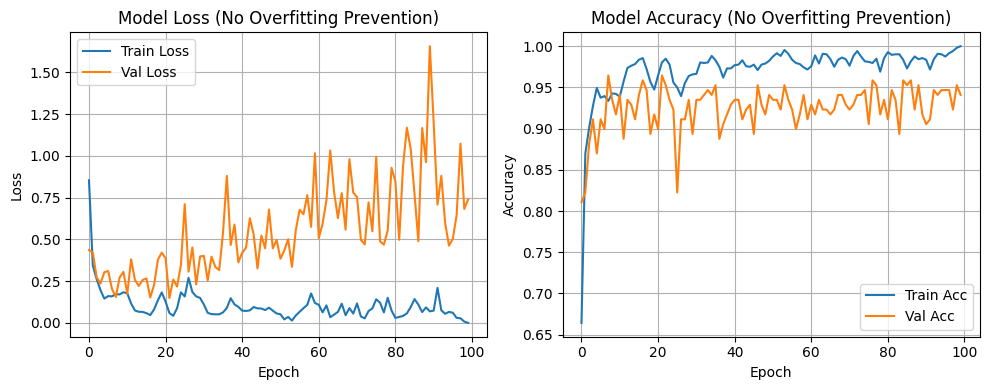

In [ ]:
# Example 1B: No Overfitting Prevention

import matplotlib.pyplot as plt

# Print title
print("Example 1B: Visualize Effects of No Overfitting Prevention")
# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# ------------------------------------------------------------------
# Plot 1: Loss (Left Graph)
# ------------------------------------------------------------------
ax1.plot(eg_history['loss'], label='Train Loss')
ax1.plot(eg_history['val_loss'], label='Val Loss')
ax1.set_title('Model Loss (No Overfitting Prevention)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# ------------------------------------------------------------------
# Plot 2: Accuracy (Right Graph)
# ------------------------------------------------------------------
ax2.plot(eg_history['accuracy'], label='Train Acc')
ax2.plot(eg_history['val_accuracy'], label='Val Acc')
ax2.set_title('Model Accuracy (No Overfitting Prevention)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

If the code is correct you should see something _similar_ to the following output

![__](https://biologicslab.co:/BIO1173/images/class_02/class_02_3_image01A.png)

If you don't set the random seed, there can be considerable variability in these plots from one run to the next. Here is an analysis of the two plots shown above.

#### **Analysis of Model Performance**

Based on the training plots, the model is exhibiting a textbook case of **overfitting**.

##### **Model Loss (Left Plot)**
* **Train Loss (Blue):** This line drops consistently and rapidly approaches 0. This indicates the model is successfully learning the training data and, by Epoch 55, has essentially "memorized" it.
* **Validation Loss (Orange):** This represents how the model performs on data it hasn't seen before. While it decreases initially, it is highly volatile (spiky) and eventually plateaus around 0.25.
* **The Gap:** The large gap between the Training Loss (near 0) and Validation Loss (~0.25) signifies that the model is fitting noise in the training data rather than generalizing the underlying patterns.

##### **Model Accuracy (Right Plot)**
* **Train Accuracy (Blue):** The model achieves perfect accuracy (1.0 or 100%) on the training data around Epoch 50 and stays there.
* **Validation Accuracy (Orange):** The validation accuracy improves quickly but hits a ceiling around 96-97%. It never reaches the perfect score of the training set.
* **Observation:** While 96% accuracy is objectively good, the fact that training is at 100% confirms the model has sufficient capacity to learn the task but lacks the constraints to ignore irrelevant details (noise).

##### **Diagnosis**
Here is what happened mechanistically:

1.  **Memorization:** The neural network is likely too complex (too many parameters/layers) relative to the amount of data available. It has enough "memory" to simply recall specific training examples rather than learning rules.
2.  **Volatility:** The spikes in the orange validation loss line (specifically between epochs 10 and 50) suggest the model is unstable. Small updates to the weights are causing large swings in error when applied to unseen data.

### **Exercise 1A: No Overfitting Prevention**

In the cell below write the code to to build, compile and train a classification neural network called `ex_model`. As usual, start by copying all of `Example 1` into the cell below.

Since you will be using the Heart Disease dataset for all of the **`Exercises`**, use this code chunk to read your dataset from the course file server and create a DataFrame called `ex_df`.
```text
# ------------------------------------------------------------
# 2️⃣  Load data
# ------------------------------------------------------------
ex_df = pd.read_csv("https://biologicslab.co/BIO1173/data/heart_disease.csv",
                    na_values=['NA','?'])

```

Your objective is to predict the kind of `Resting ECG` a patient will likely display given his/her other clinical measurements. Therefore the data in the column `RestingECG` will be your `Y-values` and the data in the other columns will be your `X-values`. Since your target column has 3 classes: `Normal`, `ST` and `LVH`, you will be training your neural network (`ex_model`) to predict which of type of Resting ECG a particular patient will likely have given his/her other clinical measurements (`X-values`).

You will therefore need to specify your target column as follows:
```text
ex_target_col = "RestingECG"
```

**Code Hints:**

Change the prefix `eg_` to `ex_` everywhere in the code copied from Example 1.

Make sure to change the value of the `seed_value` to 1604


In [ ]:
# @title Exercise 1A: No Overfitting Prevention

# ------------------------------------------------------------
# 0️⃣  Imports
# ------------------------------------------------------------
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ------------------------------------------------------------
# 1️⃣  Parameters
# ------------------------------------------------------------
EPOCHS        = 100
PATIENCE      = 10
VERBOSE       = 0     # 0 means no output during training
LEARNING_RATE = 0.05
BATCH_SIZE    = 32

# Print title
print("Exercise 1A: No Overfitting Prevention")

# Set Seed
seed_value = 1604
set_seeds(seed_value)

# Set device to GPU if available, else CPU
device = torch.device("cpu")
print(f"Using device: {device}")

# ------------------------------------------------------------
# 2️⃣  Load data
# ------------------------------------------------------------
ex_df = pd.read_csv("https://biologicslab.co/BIO1173/data/heart_disease.csv",
                    na_values=['NA','?'])
# ------------------------------------------------------------
# 3️⃣  Target (Y-values)
# ------------------------------------------------------------
ex_target_col = "RestingECG"
le = LabelEncoder()
ex_df[ex_target_col] = le.fit_transform(ex_df[ex_target_col])

ex_X = ex_df.drop(columns=[ex_target_col])
ex_y = ex_df[ex_target_col].astype('int32')

# ------------------------------------------------------------
# 4️⃣  Train–Validation–Test Split
# ------------------------------------------------------------
# First split into train+val and test
ex_X_temp, ex_X_test, ex_y_temp, ex_y_test = train_test_split(
    ex_X, ex_y, test_size=0.2, random_state=42, stratify=ex_y)

# Then split train+val into train and val
ex_X_train, ex_X_val, ex_y_train, ex_y_val = train_test_split(
    ex_X_temp, ex_y_temp, test_size=0.1, random_state=42, stratify=ex_y_temp)

# ------------------------------------------------------------
# 5️⃣  Preprocessing
# ------------------------------------------------------------
categorical_cols = [c for c in ex_X.columns if ex_X[c].dtype == "object"]
numeric_cols     = [c for c in ex_X.columns if c not in categorical_cols]

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler",  StandardScaler())
    ]), numeric_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(drop="if_binary", sparse_output=False))
    ]), categorical_cols)
])

# Convert data to correct numeric type (Numpy arrays)
ex_X_train_proc = preprocessor.fit_transform(ex_X_train).astype(np.float32)
ex_X_val_proc   = preprocessor.transform(ex_X_val).astype(np.float32)
ex_X_test_proc  = preprocessor.transform(ex_X_test).astype(np.float32)

ex_y_train = ex_y_train.to_numpy().astype(np.int32).reshape(-1)
ex_y_val   = ex_y_val.to_numpy().astype(np.int32).reshape(-1)
ex_y_test  = ex_y_test.to_numpy().astype(np.int32).reshape(-1)

# ------------------------------------------------------------
# 6️⃣  Convert to PyTorch Tensors & DataLoaders
# ------------------------------------------------------------
# Convert Features to Float Tensors
ex_X_train_t = torch.tensor(ex_X_train_proc).to(device)
ex_X_val_t   = torch.tensor(ex_X_val_proc).to(device)
ex_X_test_t  = torch.tensor(ex_X_test_proc).to(device)

# Convert Targets to Long Tensors (Required for CrossEntropyLoss)
ex_y_train_t = torch.tensor(ex_y_train, dtype=torch.long).to(device)
ex_y_val_t   = torch.tensor(ex_y_val, dtype=torch.long).to(device)
ex_y_test_t  = torch.tensor(ex_y_test, dtype=torch.long).to(device)

# Create DataLoaders for batching
ex_train_dataset = TensorDataset(ex_X_train_t, ex_y_train_t)
ex_val_dataset   = TensorDataset(ex_X_val_t, ex_y_val_t)

ex_train_loader = DataLoader(ex_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
ex_val_loader   = DataLoader(ex_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ------------------------------------------------------------
# 7️⃣  Build Model & Optimizer
# ------------------------------------------------------------
n_classes = len(np.unique(ex_y_train))
input_dim = ex_X_train_proc.shape[1]

# Define PyTorch Model
class HeartDiseaseNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(HeartDiseaseNet, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.relu = nn.ReLU()
        self.output = nn.Linear(32, output_dim)
        # Note: No Softmax here. CrossEntropyLoss expects raw logits.

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.output(x)
        return x

ex_model = HeartDiseaseNet(input_dim, n_classes).to(device)

# Define Loss and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(ex_model.parameters(), lr=LEARNING_RATE)

# ------------------------------------------------------------
# 8️⃣  Train model (Manual Loop)
# ------------------------------------------------------------
print(f"------Training Starting for {EPOCHS} epochs --------------")
start_time = time.time()

# Dictionary to store history
ex_history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

for epoch in range(EPOCHS):
    # --- Training Phase ---
    ex_model.train()
    train_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in ex_train_loader:
        optimizer.zero_grad()               # Reset gradients
        outputs = ex_model(X_batch)         # Forward pass
        loss = loss_fn(outputs, y_batch)    # Calculate loss
        loss.backward()                     # Backward pass
        optimizer.step()                    # Update weights

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    avg_train_loss = train_loss / len(ex_train_loader)
    train_acc = correct / total

    # --- Validation Phase ---
    ex_model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad(): # No gradient needed for validation
        for X_batch, y_batch in ex_val_loader:
            outputs = ex_model(X_batch)
            loss = loss_fn(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    avg_val_loss = val_loss / len(ex_val_loader)
    val_acc = correct / total

    # Store metrics
    ex_history['accuracy'].append(train_acc)
    ex_history['val_accuracy'].append(val_acc)
    ex_history['loss'].append(avg_train_loss)
    ex_history['val_loss'].append(avg_val_loss)

    # Verbose print
    if VERBOSE > 0:
        print(
            f"Epoch {epoch+1}/{EPOCHS} - "
            f"loss: {avg_train_loss:.4f} - "
            f"acc: {train_acc:.4f} - "
            f"val_loss: {avg_val_loss:.4f} - "
            f"val_acc: {val_acc:.4f}"
        )

# ---------------------------------------------------------------------------
# 9️⃣ Inspect training
# ---------------------------------------------------------------------------
print(f"\nTraining finished")
print("Best val accuracy:", max(ex_history["val_accuracy"]))
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Exercise 1A: No Overfitting Prevention
✅ Seeds set to: 1604
Using device: cpu
------Training Starting for 100 epochs --------------

Training finished
Best val accuracy: 0.6621621621621622
Elapsed time: 0:00:04.64


If the code is correct you should see something _similar_ to the following output:
```text
Exercise 1A: No Overfitting Prevention
✅ Seeds set to: 1604
Using device: cpu
------Training Starting for 100 epochs --------------

Training finished
Best val accuracy: 0.6621621621621622
Elapsed time: 0:00:02.92
```


### **Exercise 1B: Visualize Effects of No Overfitting Prevention**

In the cell below write the code to visualize your training by creating a  **train loss vs. validation loss** plot and **train accuracy vs. validation accuracy** plot.

**Code Hints:**

Your `history` object should be called `ex_history` instead of `eg_history`.

Exercise 1B: Visualize Effects of No Overfitting Prevention


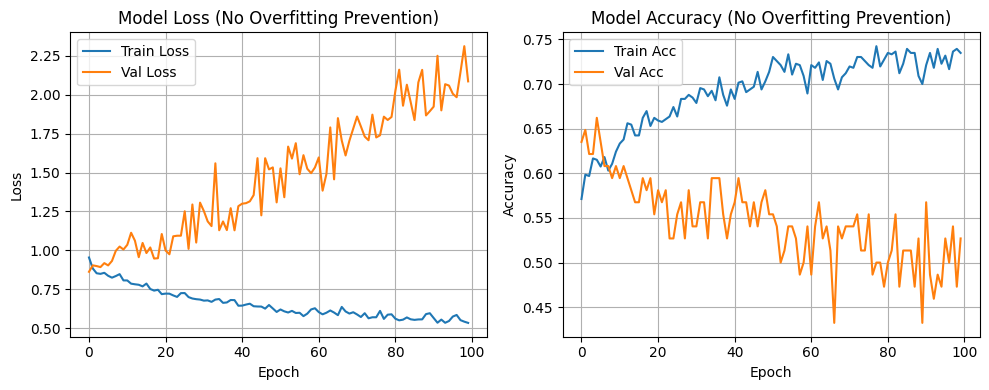

In [ ]:
# @title Exercise 1B: Visualize Effects of No Overfitting Prevention

import matplotlib.pyplot as plt

# Print title
print("Exercise 1B: Visualize Effects of No Overfitting Prevention")

# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# ------------------------------------------------------------------
# Plot 1: Loss (Left Graph)
# ------------------------------------------------------------------
ax1.plot(ex_history['loss'], label='Train Loss')
ax1.plot(ex_history['val_loss'], label='Val Loss')
ax1.set_title('Model Loss (No Overfitting Prevention)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# ------------------------------------------------------------------
# Plot 2: Accuracy (Right Graph)
# ------------------------------------------------------------------
ax2.plot(ex_history['accuracy'], label='Train Acc')
ax2.plot(ex_history['val_accuracy'], label='Val Acc')
ax2.set_title('Model Accuracy (No Overfitting Prevention)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

If the code is correct you should see something _similar_ to the following output

![__](https://biologicslab.co:/BIO1173/images/class_02/class_02_3_image02A.png)

### **Analysis of Model Performance (Severe Overfitting)**

Based on these training plots, the model is exhibiting a case of **severe overfitting**, arguably worse than the previous example because the validation performance is actively degrading rather than just stalling.

##### **Model Loss (Left Plot)**
* **Train Loss (Blue):** The training loss decreases steadily from ~1.0 down to ~0.5. This confirms the model is learning to minimize error on the training set.
* **Validation Loss (Orange):** This is the critical warning sign. Instead of decreasing or plateauing, the validation loss **increases** dramatically, rising from ~1.0 to over 3.0.
* **The Gap:** The lines diverge almost immediately (around Epoch 5). The fact that validation loss is exploding upwards indicates the model is becoming increasingly confident in its wrong predictions on unseen data.

##### **Model Accuracy (Right Plot)**
* **Train Accuracy (Blue):** The model steadily improves its accuracy on the training data, climbing from 60% to nearly 77%.
* **Validation Accuracy (Orange):** The accuracy on validation data degrades over time. It starts near 60% but drops to fluctuate between 45% and 55%—essentially performing no better (or worse) than random guessing as training continues.
* **Observation:** The model is "learning" patterns that are specific only to the training data and detrimental to generalization. As it optimizes for the training set, it actively gets worse at the general task.

##### **Diagnosis**
Here is what is happening mechanistically:

1.  **Immediate Divergence:** Unlike the previous graph where the model generalized for a while before overfitting, this model begins overfitting almost instantly.
2.  **Memorization of Noise:** The rising orange loss line suggests the model is fitting the "noise" or random fluctuations in the training data so aggressively that it is losing the underlying signal.
3.  **Potential Causes:** This specific shape (diverging lines) often hints that the model capacity is far too high for the dataset size, or the learning rate might be too high, causing the model to overshoot optimal weights for the validation set.

# **L2 Regularization (Weight Decay)**

**L2 Regularization** is a standard technique used to reduce overfitting by preventing a neural network's weights from becoming too large. In the PyTorch ecosystem, this is commonly referred to as **Weight Decay**.

##### **What is L2 Regularization?**
* **The Concept:** It adds a penalty to the model's loss function proportional to the square of the magnitude of the weights.
* **The Goal:** By penalizing large weights, the model is forced to learn simpler patterns rather than complex, high-frequency noise (memorization).
* **The Result:** The model becomes less sensitive to small changes in input data, leading to a smoother decision boundary and better generalization.

##### **How to Implement it in PyTorch**
Unlike some frameworks where you add a penalty term manually to your loss function, PyTorch builds L2 regularization directly into the **optimizer**.

You simply set the `weight_decay` parameter when initializing your optimizer.

* **Parameter:** `weight_decay` (float)
* **Typical Values:** Between `1e-5` (0.00001) and `1e-3` (0.001). A value of `0` means no regularization.

##### **Code Example**
Here is how you would add L2 regularization to an Adam optimizer:

```python
import torch
import torch.nn as nn
import torch.optim as optim

# 1. Define your model (standard step)
model = nn.Sequential(
    nn.Linear(10, 50),
    nn.ReLU(),
    nn.Linear(50, 1)
)

# 2. Define the Optimizer with L2 Regularization
# 'weight_decay=1e-4' applies the L2 penalty
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

# 3. The training loop remains exactly the same
# PyTorch automatically adds the regularization term during the optimizer.step()

### Example 2A: L2 Regularization

The following chages were made to add L2 Regularization to the code shown in Example 1.

##### **New Hyperparameter (Section 1)**
* **Example 1A:** Only defines standard training parameters (`EPOCHS`, `LEARNING_RATE`, etc.).
* **Example 2A:** Adds a specific variable for the regularization strength:
```text
  L2_REG = 0.001  # <--- New Parameter: Weight Decay Strength
```

##### **Optimizer Configuration (Section 7)**
This is the most critical functional difference. PyTorch implements L2 Regularization directly inside the optimizer via the weight_decay argument.

Example 1A (No Regularization): The optimizer is initialized with only the model parameters and learning rate.

```text
optimizer = optim.Adam(eg_model.parameters(), lr=LEARNING_RATE)
```

Example 2A (With L2 Regularization): The optimizer includes the weight_decay argument, passing in the L2_REG value defined earlier.

```text
optimizer = optim.Adam(eg_model.parameters(),
                       lr=LEARNING_RATE,
                       weight_decay=L2_REG) # <--- Applies L2 Penalty
```


In [ ]:
# Example 2A: L2 Regularization (Weight Decay)

# -------------------------------------------------------------------
# 0️⃣  Imports
# -------------------------------------------------------------------
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# -------------------------------------------------------------------
# 1️⃣  Parameters
# -------------------------------------------------------------------
EPOCHS        = 100
VERBOSE       = 0
LEARNING_RATE = 0.05
BATCH_SIZE    = 32
L2_REG        = 0.001  # <--- New Parameter: Weight Decay Strength

# Print title
print("Example 2A: L2 Regularization (Weight Decay)")

# Set Seed
seed_value = 1066
set_seeds(seed_value)

# Set device
device = torch.device("cpu")
print(f"Using device: {device}")

# -------------------------------------------------------------------
# 2️⃣  Load data
# -------------------------------------------------------------------
eg_df = pd.read_csv(
    "https://biologicslab.co/BIO1173/data/ObesityDataSet.csv",
    na_values=['NA','?']
)

# -------------------------------------------------------------------
# 3️⃣  Target (Y-values)
# -------------------------------------------------------------------
eg_target_col = "NObeyesdad"
le = LabelEncoder()
eg_df[eg_target_col] = le.fit_transform(eg_df[eg_target_col])

eg_X = eg_df.drop(columns=[eg_target_col])
eg_y = eg_df[eg_target_col].astype('int32')

# -------------------------------------------------------------------
# 4️⃣  Train–Validation–Test Split
# -------------------------------------------------------------------
eg_X_temp, eg_X_test, eg_y_temp, eg_y_test = train_test_split(
    eg_X, eg_y, test_size=0.2, random_state=42, stratify=eg_y
)

eg_X_train, eg_X_val, eg_y_train, eg_y_val = train_test_split(
    eg_X_temp, eg_y_temp, test_size=0.1, random_state=42, stratify=eg_y_temp
)

# -------------------------------------------------------------------
# 5️⃣  Preprocessing
# -------------------------------------------------------------------
categorical_cols = [c for c in eg_X.columns if eg_X[c].dtype == "object"]
numeric_cols     = [c for c in eg_X.columns if c not in categorical_cols]

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler",  StandardScaler())
    ]), numeric_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(drop="if_binary", sparse_output=False))
    ]), categorical_cols)
])

# Fit & transform training data
eg_X_train_proc = preprocessor.fit_transform(eg_X_train).astype(np.float32)
eg_X_val_proc   = preprocessor.transform(eg_X_val).astype(np.float32)
eg_X_test_proc  = preprocessor.transform(eg_X_test).astype(np.float32)

eg_y_train = eg_y_train.to_numpy().astype(np.int32).reshape(-1)
eg_y_val   = eg_y_val.to_numpy().astype(np.int32).reshape(-1)
eg_y_test  = eg_y_test.to_numpy().astype(np.int32).reshape(-1)

# -------------------------------------------------------------------
# 6️⃣  Convert to PyTorch Tensors & DataLoaders
# -------------------------------------------------------------------
eg_X_train_t = torch.tensor(eg_X_train_proc).to(device)
eg_X_val_t   = torch.tensor(eg_X_val_proc).to(device)
eg_X_test_t  = torch.tensor(eg_X_test_proc).to(device)

eg_y_train_t = torch.tensor(eg_y_train, dtype=torch.long).to(device)
eg_y_val_t   = torch.tensor(eg_y_val, dtype=torch.long).to(device)
eg_y_test_t  = torch.tensor(eg_y_test, dtype=torch.long).to(device)

eg_train_dataset = TensorDataset(eg_X_train_t, eg_y_train_t)
eg_val_dataset   = TensorDataset(eg_X_val_t, eg_y_val_t)

eg_train_loader = DataLoader(eg_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
eg_val_loader   = DataLoader(eg_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# -------------------------------------------------------------------
# 7️⃣  Build Model (Standard)
# -------------------------------------------------------------------
n_classes = len(np.unique(eg_y_train))
input_dim = eg_X_train_proc.shape[1]

class ObesityNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ObesityNet, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.relu = nn.ReLU()
        # No Dropout layer here, we are testing L2 specifically
        self.output = nn.Linear(32, output_dim)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.output(x)
        return x

eg_model = ObesityNet(input_dim, n_classes).to(device)

loss_fn = nn.CrossEntropyLoss()

# 'weight_decay' applies L2 penalty to the parameters
optimizer = optim.Adam(eg_model.parameters(),
                       lr=LEARNING_RATE,
                       weight_decay=L2_REG)

# -------------------------------------------------------------------
# 8️⃣  Train model
# -------------------------------------------------------------------
print(f"------Training Starting for {EPOCHS} epochs --------------")
start_time = time.time()

eg_history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

for epoch in range(EPOCHS):
    # --- Training Phase ---
    eg_model.train()
    train_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in eg_train_loader:
        optimizer.zero_grad()
        outputs = eg_model(X_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    avg_train_loss = train_loss / len(eg_train_loader)
    train_acc = correct / total

    # --- Validation Phase ---
    eg_model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in eg_val_loader:
            outputs = eg_model(X_batch)
            loss = loss_fn(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    avg_val_loss = val_loss / len(eg_val_loader)
    val_acc = correct / total

    # Store metrics
    eg_history['accuracy'].append(train_acc)
    eg_history['val_accuracy'].append(val_acc)
    eg_history['loss'].append(avg_train_loss)
    eg_history['val_loss'].append(avg_val_loss)

    # Print if verbose
    if VERBOSE > 0:
        print(
            f"Epoch {epoch+1}/{EPOCHS} - "
            f"loss: {avg_train_loss:.4f} - "
            f"acc: {train_acc:.4f} - "
            f"val_loss: {avg_val_loss:.4f} - "
            f"val_acc: {val_acc:.4f}"
        )

# ---------------------------------------------------------------------------
# 9️⃣ Inspect training
# ---------------------------------------------------------------------------
print(f"\nTraining finished")
print("Best val accuracy:", max(eg_history["val_accuracy"]))
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Example 2A: L2 Regularization (Weight Decay)
✅ Seeds set to: 1066
Using device: cpu
------Training Starting for 100 epochs --------------

Training finished
Best val accuracy: 0.9704142011834319
Elapsed time: 0:00:07.69


If the code is correct you should see something _similar_ to the following output:

```text
Example 2A: L2 Regularization (Weight Decay)
✅ Seeds set to: 1066
Using device: cpu
------Training Starting for 100 epochs --------------

Training finished
Best val accuracy: 0.9704142011834319
Elapsed time: 0:00:07.69
```

### Example 2B: Visualize Effects of `L2 Regularization`.

The code in the cell below is **exactly** the same as that used in `Example 1B` except the axis titles have been changed to specify the type of overfitting protection that was used.

Example 2B: Visualize Effects of L2 Regularization


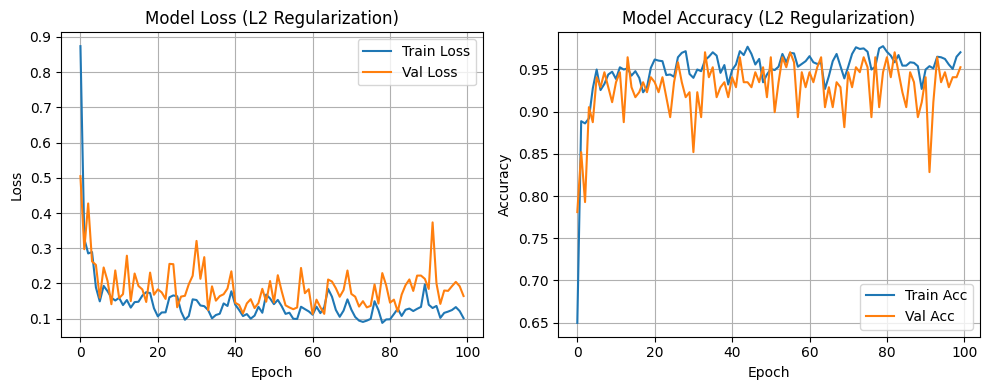

In [ ]:
# Example 2B: Visualize Effects of L2 Regularization

import matplotlib.pyplot as plt

# Print title
print("Example 2B: Visualize Effects of L2 Regularization")

# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# ------------------------------------------------------------------
# Plot 1: Loss (Left Graph)
# ------------------------------------------------------------------
ax1.plot(eg_history['loss'], label='Train Loss')
ax1.plot(eg_history['val_loss'], label='Val Loss')
ax1.set_title('Model Loss (L2 Regularization)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# ------------------------------------------------------------------
# Plot 2: Accuracy (Right Graph)
# ------------------------------------------------------------------
ax2.plot(eg_history['accuracy'], label='Train Acc')
ax2.plot(eg_history['val_accuracy'], label='Val Acc')
ax2.set_title('Model Accuracy (L2 Regularization)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

If the code is correct you should see something _similar_ to these graphs.

![__](https://biologicslab.co:/BIO1173/images/class_02/class_02_3_image03A.png)

### **Comparative Analysis: L2 Regularization vs. No Prevention**

These two sets of graphs provide a stark "Before and After" demonstration of how **L2 Regularization** (Weight Decay) stabilizes model training.

##### **1. Top Graphs: Model with L2 Regularization**
* **Model Loss (Left):** The most critical observation here is the **tight coupling** between the Training Loss (Blue) and Validation Loss (Orange). Unlike the chaotic divergence seen previously, the Validation line roughly follows the Training line downwards. They settle near each other (~0.1 for Train, ~0.2 for Val).
* **Model Accuracy (Right):** The Validation Accuracy tracks the Training Accuracy very closely, reaching high performance (~95%).
* **Diagnosis:** **Successful Generalization.** The L2 penalty effectively constrained the model weights. Instead of memorizing noise, the model was forced to learn robust patterns that applied equally well to unseen data.

##### **2. Bottom Graphs: Model without Overfitting Prevention**
* **Model Loss (Left):** This represents a catastrophic failure. While the Training Loss drops, the Validation Loss **explodes upwards** (from 1.0 to 3.5). The lines diverge immediately.
* **Model Accuracy (Right):** The Training Accuracy climbs to ~77%, but the Validation Accuracy collapses to ~50% (essentially random guessing).
* **Diagnosis:** **Severe Overfitting / Instability.** Without the constraint of L2 regularization, the model likely learned large, unstable weights that worked for the training data but produced massive errors on the validation data.

##### **Key Takeaway**
The addition of `weight_decay` in the optimizer turned a failing model (Bottom) into a highly accurate one (Top).
* **Without L2:** The model became "over-confident" on training data, leading to massive errors on validation data.
* **With L2:** The model remained "disciplined," sacrificing a tiny bit of training perfection for massive gains in validation stability and accuracy.

### **Exercise 2A: L2 Regularization**

Follow these step-by-step instructions to convert your Exercise 1A code (without L2 regularization) into Exercise 2A code (with L2 regularization).

#### **Step 1: Set seed Parameter**

Set the `seed_value` = 1948
---

#### **Step 2: Add L2_REG Parameter**

**Location:** Section 1️⃣ Parameters (around line 18)

**Add this new line after BATCH_SIZE:**

    L2_REG = 0.01  # L2 regularization strength (weight decay)

**Why:** This parameter controls the strength of L2 regularization. Common values range from 0.0001 to 0.1. A value of 0.01 is a good starting point.

---

#### **Step 3: Update Optimizer with Weight Decay**

**Location:** Section 7️⃣ Build Model & Optimizer (around line 122)

**Original code:**

    optimizer = optim.Adam(ex_model.parameters(), lr=LEARNING_RATE)

**New code:**

    optimizer = optim.Adam(ex_model.parameters(),
                           lr=LEARNING_RATE,
                           weight_decay=L2_REG)  # Apply L2 Penalty

**Why:** The weight_decay parameter implements L2 regularization in PyTorch. It adds a penalty to the loss function proportional to the magnitude of the weights, which helps prevent overfitting by discouraging large weight values.

---

#### **Summary of Changes**

1. Set seed value to 1948
2. Added L2_REG parameter (set to 0.01)
3. Modified optimizer to include weight_decay=L2_REG

---

### **What L2 Regularization Does**

**L2 regularization** (also called weight decay) is a technique to prevent overfitting by:
- Adding a penalty term to the loss function based on the magnitude of model weights
- Encouraging the model to keep weights small
- Preventing the model from relying too heavily on any single feature
- Improving generalization to new data

The regularization penalty is calculated as: **lambda × sum(weight²)** where lambda is the L2_REG value.

**Effect on training:**
- Training accuracy may be slightly lower
- Validation accuracy often improves
- The model becomes more robust and generalizes better

---

#### **Experimenting with L2 Regularization**

You can experiment with different L2_REG values to find the optimal amount of regularization:

- **L2_REG = 0.0:** No regularization (same as Exercise 1A)
- **L2_REG = 0.001:** Light regularization
- **L2_REG = 0.01:** Moderate regularization (recommended starting point)
- **L2_REG = 0.1:** Strong regularization
- **L2_REG = 1.0:** Very strong regularization (may underfit)

**Too little regularization:** Model may overfit (high training accuracy, low validation accuracy)

**Too much regularization:** Model may underfit (low training and validation accuracy)

---

#### **Quick Checklist**

Before running your code, verify you have made these changes:

- Step 1: Added L2_REG parameter in the Parameters section
- Step 2: Added weight_decay=L2_REG to the optimizer

Once you've completed both steps, run your code and compare the results to Exercise 1A. You should observe how L2 regularization affects the training and validation accuracy!

---

#### **Expected Behavior**

When you run this code with L2 regularization:
- The model weights will be penalized for being too large
- Training may take slightly longer to converge
- Validation accuracy may improve compared to Exercise 1A
- The gap between training and validation accuracy may decrease
- The model should generalize better to unseen data


In [ ]:
# @title Exercise 2A: L2 Regularization

# ------------------------------------------------------------
# 0️⃣  Imports
# ------------------------------------------------------------
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ------------------------------------------------------------
# 1️⃣  Parameters
# ------------------------------------------------------------
EPOCHS        = 100
PATIENCE      = 10
VERBOSE       = 0     # 0 means no output during training
LEARNING_RATE = 0.05
BATCH_SIZE    = 32

# Print title
print("Exercise 2A: L2 Regularization")

# Set Seed
seed_value = 1948
set_seeds(seed_value)

# Set device to GPU if available, else CPU
device = torch.device("cpu")
print(f"Using device: {device}")

# ------------------------------------------------------------
# 2️⃣  Load data
# ------------------------------------------------------------
ex_df = pd.read_csv("https://biologicslab.co/BIO1173/data/heart_disease.csv",
                    na_values=['NA','?'])
# ------------------------------------------------------------
# 3️⃣  Target (Y-values)
# ------------------------------------------------------------
ex_target_col = "RestingECG"
le = LabelEncoder()
ex_df[ex_target_col] = le.fit_transform(ex_df[ex_target_col])

ex_X = ex_df.drop(columns=[ex_target_col])
ex_y = ex_df[ex_target_col].astype('int32')

# ------------------------------------------------------------
# 4️⃣  Train–Validation–Test Split
# ------------------------------------------------------------
# First split into train+val and test
ex_X_temp, ex_X_test, ex_y_temp, ex_y_test = train_test_split(
    ex_X, ex_y, test_size=0.2, random_state=42, stratify=ex_y)

# Then split train+val into train and val
ex_X_train, ex_X_val, ex_y_train, ex_y_val = train_test_split(
    ex_X_temp, ex_y_temp, test_size=0.1, random_state=42, stratify=ex_y_temp)

# ------------------------------------------------------------
# 5️⃣  Preprocessing
# ------------------------------------------------------------
categorical_cols = [c for c in ex_X.columns if ex_X[c].dtype == "object"]
numeric_cols     = [c for c in ex_X.columns if c not in categorical_cols]

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler",  StandardScaler())
    ]), numeric_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(drop="if_binary", sparse_output=False))
    ]), categorical_cols)
])

# Convert data to correct numeric type (Numpy arrays)
ex_X_train_proc = preprocessor.fit_transform(ex_X_train).astype(np.float32)
ex_X_val_proc   = preprocessor.transform(ex_X_val).astype(np.float32)
ex_X_test_proc  = preprocessor.transform(ex_X_test).astype(np.float32)

ex_y_train = ex_y_train.to_numpy().astype(np.int32).reshape(-1)
ex_y_val   = ex_y_val.to_numpy().astype(np.int32).reshape(-1)
ex_y_test  = ex_y_test.to_numpy().astype(np.int32).reshape(-1)

# ------------------------------------------------------------
# 6️⃣  Convert to PyTorch Tensors & DataLoaders
# ------------------------------------------------------------
# Convert Features to Float Tensors
ex_X_train_t = torch.tensor(ex_X_train_proc).to(device)
ex_X_val_t   = torch.tensor(ex_X_val_proc).to(device)
ex_X_test_t  = torch.tensor(ex_X_test_proc).to(device)

# Convert Targets to Long Tensors (Required for CrossEntropyLoss)
ex_y_train_t = torch.tensor(ex_y_train, dtype=torch.long).to(device)
ex_y_val_t   = torch.tensor(ex_y_val, dtype=torch.long).to(device)
ex_y_test_t  = torch.tensor(ex_y_test, dtype=torch.long).to(device)

# Create DataLoaders for batching
ex_train_dataset = TensorDataset(ex_X_train_t, ex_y_train_t)
ex_val_dataset   = TensorDataset(ex_X_val_t, ex_y_val_t)

ex_train_loader = DataLoader(ex_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
ex_val_loader   = DataLoader(ex_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ------------------------------------------------------------
# 7️⃣  Build Model & Optimizer
# ------------------------------------------------------------
n_classes = len(np.unique(ex_y_train))
input_dim = ex_X_train_proc.shape[1]

# Define PyTorch Model
class HeartDiseaseNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(HeartDiseaseNet, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.relu = nn.ReLU()
        self.output = nn.Linear(32, output_dim)
        # Note: No Softmax here. CrossEntropyLoss expects raw logits.

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.output(x)
        return x

ex_model = HeartDiseaseNet(input_dim, n_classes).to(device)

# Define Loss and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(ex_model.parameters(),
                       lr=LEARNING_RATE,
                       weight_decay=L2_REG) # Apply L2 Penalty

# ------------------------------------------------------------
# 8️⃣  Train model (Manual Loop)
# ------------------------------------------------------------
print(f"------Training Starting for {EPOCHS} epochs --------------")
start_time = time.time()

# Dictionary to store history
ex_history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

for epoch in range(EPOCHS):
    # --- Training Phase ---
    ex_model.train()
    train_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in ex_train_loader:
        optimizer.zero_grad()               # Reset gradients
        outputs = ex_model(X_batch)         # Forward pass
        loss = loss_fn(outputs, y_batch)    # Calculate loss
        loss.backward()                     # Backward pass
        optimizer.step()                    # Update weights

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    avg_train_loss = train_loss / len(ex_train_loader)
    train_acc = correct / total

    # --- Validation Phase ---
    ex_model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad(): # No gradient needed for validation
        for X_batch, y_batch in ex_val_loader:
            outputs = ex_model(X_batch)
            loss = loss_fn(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    avg_val_loss = val_loss / len(ex_val_loader)
    val_acc = correct / total

    # Store metrics
    ex_history['accuracy'].append(train_acc)
    ex_history['val_accuracy'].append(val_acc)
    ex_history['loss'].append(avg_train_loss)
    ex_history['val_loss'].append(avg_val_loss)

    # Verbose print
    if VERBOSE > 0:
        print(
            f"Epoch {epoch+1}/{EPOCHS} - "
            f"loss: {avg_train_loss:.4f} - "
            f"acc: {train_acc:.4f} - "
            f"val_loss: {avg_val_loss:.4f} - "
            f"val_acc: {val_acc:.4f}"
        )

# ---------------------------------------------------------------------------
# 9️⃣ Inspect training
# ---------------------------------------------------------------------------
print(f"\nTraining finished")
print("Best val accuracy:", max(ex_history["val_accuracy"]))
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Exercise 2A: L2 Regularization
✅ Seeds set to: 1948
Using device: cpu
------Training Starting for 100 epochs --------------

Training finished
Best val accuracy: 0.6486486486486487
Elapsed time: 0:00:04.99


If the code is correct you should see something _similar_ to the following output:
```text
Exercise 2A: L2 Regularization
✅ Seeds set to: 1948
Using device: cpu
------Training Starting for 100 epochs --------------

Training finished
Best val accuracy: 0.6486486486486487
Elapsed time: 0:00:04.99
```

### **Exercise 2B: Visualize Effects of L2 Regularization**

To visualize the effects of L2 Regularization, `copy-and-paste` the code from **`Exercise 1B`** into the cell below.

**Code Hints:**
1. Change the axis title for the left graph to read:
```text
ax1.set_title('Model Loss (L2 Regularization)')
```
2. Change the axis title for the right graph to read:
```text
ax2.set_title('Model Accuracy (L2 Regularization)')
```

Exercise 2B: Visualize Effects of L2 Regularization


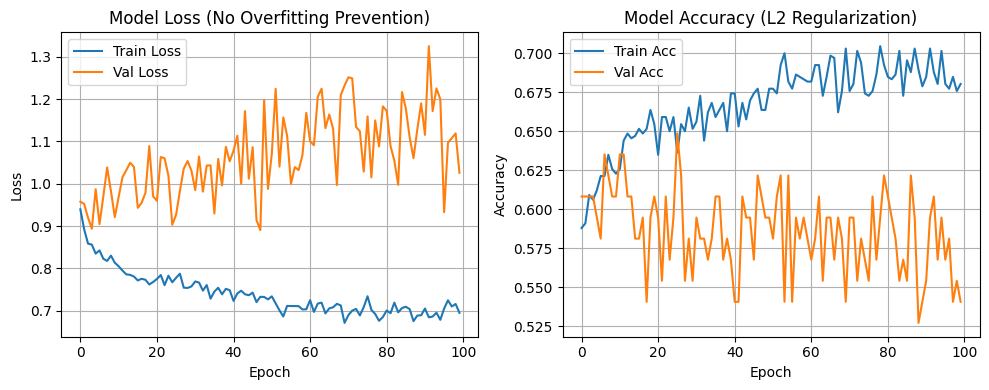

In [ ]:
# @title Exercise 2B: Visualize Effects of L2 Regularization

import matplotlib.pyplot as plt

# Print title
print("Exercise 2B: Visualize Effects of L2 Regularization")

# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# ------------------------------------------------------------------
# Plot 1: Loss (Left Graph)
# ------------------------------------------------------------------
ax1.plot(ex_history['loss'], label='Train Loss')
ax1.plot(ex_history['val_loss'], label='Val Loss')
ax1.set_title('Model Loss (No Overfitting Prevention)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# ------------------------------------------------------------------
# Plot 2: Accuracy (Right Graph)
# ------------------------------------------------------------------
ax2.plot(ex_history['accuracy'], label='Train Acc')
ax2.plot(ex_history['val_accuracy'], label='Val Acc')
ax2.set_title('Model Accuracy (L2 Regularization)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



If the code is correct you should see something _similar_ to the following output

![__](https://biologicslab.co:/BIO1173/images/class_02/class_02_3_image04A.png)


### **Comparative Analysis: Exercise 2A vs. Exercise 1A (Heart Disease Dataset)**

This analysis compares the performance of the neural network on the **Heart Disease** dataset (Target: `RestingECG`) with and without L2 Regularization.

##### **1. The Baseline: Exercise 1A (Image 02E - No Prevention)**
* **Behavior:** This graph represents the "worst-case scenario" for the `RestingECG` classification task.
* **Loss:** The Training Loss (Blue) drops smoothly, but the Validation Loss (Orange) explodes violently, rising from **~1.0 to over 3.0**.
* **Accuracy:** While Training Accuracy reaches ~77%, the Validation Accuracy degrades to ~50% (random guessing).
* **Diagnosis:** The model completely memorized the training data and failed to learn any generalizable features about the `RestingECG` patterns.

##### **2. The Attempted Fix: Exercise 2A (Image 04E - L2 Regularization)**
* **Behavior:** This model introduced **L2 Regularization** (Weight Decay) to penalize large weights.
* **Loss Comparison:**
    * **The Improvement:** The regularization *did* have an effect. The peak Validation Loss dropped from **>3.0** (in Exercise 1A) to **~1.4**. The "explosion" was dampened.
    * **The Failure:** Despite the lower peak, the lines still diverge significantly. The Validation Loss is still increasing, not decreasing.
* **Accuracy Comparison:**
    * The Validation Accuracy remains highly volatile and low (fluctuating between 45% and 60%). It did not significantly improve over the baseline.
* **Diagnosis:** **Insufficient Regularization.** The L2 penalty used in this exercise was likely too weak (e.g., a low `weight_decay` value). It curbed the extreme numeric instability seen in Exercise 1A but was not strong enough to force the model to learn a robust solution for the `RestingECG` target.

##### **Summary**
| Exercise | Technique | Val Loss Peak | Outcome |
| :--- | :--- | :--- | :--- |
| **Exercise 1A** | None | **~3.5** | **Catastrophic Overfitting** |
| **Exercise 2A** | L2 Regularization | **~1.4** | **Dampened Overfitting** (Partial effect, but still failing to generalize) |

# **Dropout to Decrease Overfitting**

Hinton, Srivastava, Krizhevsky, Sutskever, & Salakhutdinov (2012) introduced the **_dropout regularization_** algorithm.

Although `dropout` works differently than `L2 Regularization`, it accomplishes the same goal—the prevention of **overfitting**. However, the algorithm does the task by actually **_removing_** neurons and connections—at least temporarily. Unlike `L2`, no weight penalty is added. `Dropout` does not directly seek to train small weights.

`Dropout` works by causing hidden neurons of the neural network to be unavailable during part of the training. Dropping part of the neural network causes the remaining portion to be trained to still achieve a good score even without the dropped neurons. This technique decreases co-adaptation between neurons, which results in less overfitting.

**Implementation in PyTorch**

In PyTorch, `dropout` is implemented as a specific module (`nn.Dropout`) that is inserted into the model architecture, typically immediately after a dense (linear) layer or an activation function. The `nn.Dropout` module does not contain learnable weights itself; instead, it applies a "mask" to the data flowing through it.

A critical aspect of using Dropout in PyTorch is managing the model's **state**:

1.  **Training Mode (`model.train()`):** When the model is in training mode, the dropout layer is **active**. It randomly zeroes out (drops) a percentage of the elements in the input tensor based on the probability `p` you define.
2.  **Evaluation Mode (`model.eval()`):** When the model is in evaluation mode (used for validation or testing), the dropout layer is **inactive**. It allows all data to pass through unchanged, ensuring that the full capacity of the network is used for making predictions.

**How it Works Mechanically**

PyTorch implements the `dropout layer` by temporarily masking neurons rather than permanently removing them. In other words, a dropout layer does **_not_** lose any of its neurons during the training process, and the model will still have the same number of neurons after training.

This figure shows how a dropout layer might be situated with other layers.
![Dropout Regularization](https://biologicslab.co/BIO1173/images/class_02/class_9_dropout.png "Dropout Regularization")

**Dropout Regularization**

The discarded neurons and their connections are shown as dashed lines. The input layer has two input neurons as well as a bias neuron. The second layer is a dense layer with three neurons and a bias neuron. The third layer shows the effect of dropout, where regular neurons are "masked" (ignored) even though they still exist in the architecture.

While PyTorch drops these neurons during a training step, it neither calculates gradients for them nor updates their incoming weights. However, the final neural network will use _all_ of these neurons for the output when you switch to `model.eval()`.

The specific neurons that are dropped change constantly. Although we might choose a probability of 50% for dropout, the computer will not necessarily drop exactly half the neurons every time. It is as if we flipped a coin for each of the dropout candidate neurons to choose if that neuron was dropped out. In PyTorch, a new random mask is generated for every **batch** of data during the forward pass.

*Note: The bias neuron is typically never dropped; only the regular neurons connected to a dropout layer are candidates for removal.*

# **Why does Dropout work?**

A common question is why simply removing neurons would decrease overfitting. The answer lies in two main mechanisms: preventing **co-adaptation** (codependency) and simulating **ensemble learning**.

### **1. Reducing Co-adaptation**
Dropout reduces the chance of **codependency** developing between neurons. In a standard network, neurons can learn to fix up the mistakes of other neurons, creating complex co-adaptations that do not generalize to unseen data.

When dropout is applied, a neuron can no longer rely on the presence of specific other neurons because they might be deactivated at any moment. This forces each neuron to be more robust and independent, learning features that are useful in a wide variety of contexts rather than just in specific combinations. As the attached video explains, this forces the network to learn a **redundant representation** of the data—ensuring that if one pathway is "squashed," the information still flows through another.

### **2. The Ensemble Effect (Bootstrapping)**
Dropout also functions as a highly efficient form of **Ensemble Learning**.

**Ensembling** is a standard machine learning technique where multiple models are combined to produce a better result than any individual model could achieve alone. (The term originates from musical ensembles, where the final sound is a harmonious combination of many instruments).

One common ensemble method involves **Bootstrapping** (or Bagging), where a practitioner trains several independent neural networks on the same task. Because of random initialization and data sampling, each network makes different errors. When you average their outputs, the errors cancel out, resulting in a stronger, more generalized prediction.

**How Dropout Mimics This:**
Dropout mathematically approximates training a massive ensemble of different neural networks with shared weights.
* **During Training:** Every time a batch of data is processed, a random set of neurons is dropped. This effectively creates a slightly different, "thinned" neural network for that specific step. Over many iterations, you are training exponentially many different variations of the network.
* **During Testing:** When we stop dropping neurons (evaluation mode), we are essentially using a single "averaged" network that represents the consensus of all those temporary, thinned networks.

Unlike traditional ensembling, which requires training and storing many separate models (computationally expensive), dropout allows you to achieve the same robustness within a **single model**.

### **Video Explanation**
This short `YouTube` video by Udacity provides a clear visualization of how dropout forces the network to learn redundant representations:

In [ ]:
from IPython.display import HTML
video_id = "NhZVe50QwPM"
HTML(f"""
<iframe width="560" height="315"
  src="https://www.youtube.com/embed/{video_id}"
  title="YouTube video player"
  frameborder="0"
  allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture"
  allowfullscreen
  referrerpolicy="strict-origin-when-cross-origin">
</iframe>
""")

### Example 3A: Dropout

The code in the cell below is an **exact** copy of the code in `Example 1A` with the following changes to the Model Architecture and Parameters to implement Dropout.

##### **1. New Hyperparameter (Section 1)**
Example 3A introduces a probability parameter that defines how aggressive the dropout should be.

* **Code Change:**
```text
    DROPOUT_RATE = 0.5   # <--- New Parameter
```
* **Purpose:** This tells the model to randomly zero out 50% of the neurons in the hidden layer during every training step.

##### **2. Model Architecture (Section 7)**
This is where the actual structure of the neural network changes.

* **In `__init__`:** A specific Dropout layer is defined using the standard PyTorch module `nn.Dropout`.
* **In `forward`:** The dropout layer is applied to the data stream, typically immediately after the activation function (ReLU).

**Difference in Code:**
```text
class ObesityNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ObesityNet, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.relu = nn.ReLU()
        
        # --- ADDED IN EXAMPLE 3A ---
        self.dropout = nn.Dropout(p=DROPOUT_RATE)
        # ---------------------------
        
        self.output = nn.Linear(32, output_dim)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        
        # --- ADDED IN EXAMPLE 3A ---
        x = self.dropout(x)  # Apply mask here
        # ---------------------------
        
        x = self.output(x)
        return x
```


In [ ]:
# Example 3A: Dropout

# -------------------------------------------------------------------
# 0️⃣  Imports
# -------------------------------------------------------------------
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# -------------------------------------------------------------------
# 1️⃣  Parameters
# -------------------------------------------------------------------
EPOCHS        = 100
PATIENCE      = 10
VERBOSE       = 0
LEARNING_RATE = 0.05
BATCH_SIZE    = 32
DROPOUT_RATE  = 0.5   # <--- New Parameter: Probability of zeroing a neuron

# Print title
print("Example 3A: Dropout")

# Set Seed
seed_value = 1234
set_seeds(seed_value)

# Set device
device = torch.device("cpu")
print(f"Using device: {device}")

# -------------------------------------------------------------------
# 2️⃣  Load data
# -------------------------------------------------------------------
eg_df = pd.read_csv(
    "https://biologicslab.co/BIO1173/data/ObesityDataSet.csv",
    na_values=['NA','?']
)

# -------------------------------------------------------------------
# 3️⃣  Target (Y-values)
# -------------------------------------------------------------------
eg_target_col = "NObeyesdad"
le = LabelEncoder()
eg_df[eg_target_col] = le.fit_transform(eg_df[eg_target_col])

eg_X = eg_df.drop(columns=[eg_target_col])
eg_y = eg_df[eg_target_col].astype('int32')

# -------------------------------------------------------------------
# 4️⃣  Train–Validation–Test Split
# -------------------------------------------------------------------
eg_X_temp, eg_X_test, eg_y_temp, eg_y_test = train_test_split(
    eg_X, eg_y, test_size=0.2, random_state=42, stratify=eg_y
)

eg_X_train, eg_X_val, eg_y_train, eg_y_val = train_test_split(
    eg_X_temp, eg_y_temp, test_size=0.1, random_state=42, stratify=eg_y_temp
)

# -------------------------------------------------------------------
# 5️⃣  Preprocessing
# -------------------------------------------------------------------
categorical_cols = [c for c in eg_X.columns if eg_X[c].dtype == "object"]
numeric_cols     = [c for c in eg_X.columns if c not in categorical_cols]

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler",  StandardScaler())
    ]), numeric_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(drop="if_binary", sparse_output=False))
    ]), categorical_cols)
])

# Fit & transform training data
eg_X_train_proc = preprocessor.fit_transform(eg_X_train).astype(np.float32)
eg_X_val_proc   = preprocessor.transform(eg_X_val).astype(np.float32)
eg_X_test_proc  = preprocessor.transform(eg_X_test).astype(np.float32)

eg_y_train = eg_y_train.to_numpy().astype(np.int32).reshape(-1)
eg_y_val   = eg_y_val.to_numpy().astype(np.int32).reshape(-1)
eg_y_test  = eg_y_test.to_numpy().astype(np.int32).reshape(-1)

# -------------------------------------------------------------------
# 6️⃣  Convert to PyTorch Tensors & DataLoaders
# -------------------------------------------------------------------
eg_X_train_t = torch.tensor(eg_X_train_proc).to(device)
eg_X_val_t   = torch.tensor(eg_X_val_proc).to(device)
eg_X_test_t  = torch.tensor(eg_X_test_proc).to(device)

eg_y_train_t = torch.tensor(eg_y_train, dtype=torch.long).to(device)
eg_y_val_t   = torch.tensor(eg_y_val, dtype=torch.long).to(device)
eg_y_test_t  = torch.tensor(eg_y_test, dtype=torch.long).to(device)

eg_train_dataset = TensorDataset(eg_X_train_t, eg_y_train_t)
eg_val_dataset   = TensorDataset(eg_X_val_t, eg_y_val_t)

eg_train_loader = DataLoader(eg_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
eg_val_loader   = DataLoader(eg_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# -------------------------------------------------------------------
# 7️⃣  Build Model with Dropout (Standard PyTorch Practice)
# -------------------------------------------------------------------
n_classes = len(np.unique(eg_y_train))
input_dim = eg_X_train_proc.shape[1]

class ObesityNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ObesityNet, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.relu = nn.ReLU()
        # Dropout Layer: Randomly zeroes some elements of the input tensor
        self.dropout = nn.Dropout(p=DROPOUT_RATE)
        self.output = nn.Linear(32, output_dim)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)  # Apply Dropout after activation
        x = self.output(x)
        return x

eg_model = ObesityNet(input_dim, n_classes).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(eg_model.parameters(), lr=LEARNING_RATE)

# -------------------------------------------------------------------
# 8️⃣  Train model (Standard Loop - No Manual L1 Math needed)
# -------------------------------------------------------------------
print(f"------Training Starting for {EPOCHS} epochs --------------")
start_time = time.time()

eg_history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

for epoch in range(EPOCHS):
    # --- Training Phase ---
    eg_model.train() # Important: Enables Dropout
    train_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in eg_train_loader:
        optimizer.zero_grad()
        outputs = eg_model(X_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    avg_train_loss = train_loss / len(eg_train_loader)
    train_acc = correct / total

    # --- Validation Phase ---
    eg_model.eval() # Important: Disables Dropout (uses full network)
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in eg_val_loader:
            outputs = eg_model(X_batch)
            loss = loss_fn(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    avg_val_loss = val_loss / len(eg_val_loader)
    val_acc = correct / total

    # Store metrics
    eg_history['accuracy'].append(train_acc)
    eg_history['val_accuracy'].append(val_acc)
    eg_history['loss'].append(avg_train_loss)
    eg_history['val_loss'].append(avg_val_loss)

    # Print if verbose
    if VERBOSE > 0:
        print(
            f"Epoch {epoch+1}/{EPOCHS} - "
            f"loss: {avg_train_loss:.4f} - "
            f"acc: {train_acc:.4f} - "
            f"val_loss: {avg_val_loss:.4f} - "
            f"val_acc: {val_acc:.4f}"
        )

# ---------------------------------------------------------------------------
# 9️⃣ Inspect training
# ---------------------------------------------------------------------------
print(f"\nTraining finished")
print("Best val accuracy:", max(eg_history["val_accuracy"]))
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Example 3A: Dropout
✅ Seeds set to: 1234
Using device: cpu
------Training Starting for 100 epochs --------------

Training finished
Best val accuracy: 0.9526627218934911
Elapsed time: 0:00:11.54


If the code is correct you should see something _similar_ to the last part of the output:
```text
Example 3A: Dropout
✅ Seeds set to: 1234
Using device: cpu
------Training Starting for 100 epochs --------------

Training finished
Best val accuracy: 0.9526627218934911
Elapsed time: 0:00:11.54
```

### Example 3B: Visualize Effects of Dropout

The code in the cell below is **exactly** the same as that used in `Example 1B` except the axis titles have been changed to specify the type of overfitting protection that was used.

Example 3B: Visualize Effects of Dropout


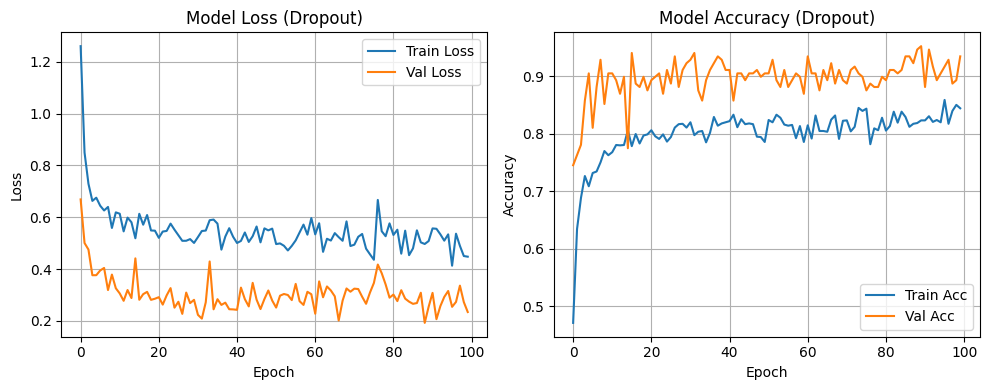

In [ ]:
# Example 3B: Visualize Effects of Dropout

import matplotlib.pyplot as plt

# Print title
print("Example 3B: Visualize Effects of Dropout")

# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# ------------------------------------------------------------------
# Plot 1: Loss (Left Graph)
# ------------------------------------------------------------------
ax1.plot(eg_history['loss'], label='Train Loss')
ax1.plot(eg_history['val_loss'], label='Val Loss')
ax1.set_title('Model Loss (Dropout)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# ------------------------------------------------------------------
# Plot 2: Accuracy (Right Graph)
# ------------------------------------------------------------------
ax2.plot(eg_history['accuracy'], label='Train Acc')
ax2.plot(eg_history['val_accuracy'], label='Val Acc')
ax2.set_title('Model Accuracy (Dropout)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

If the code is correct you should see something _similar_ to the following output

![__](https://biologicslab.co:/BIO1173/images/class_02/class_02_3_image05A.png)


### **Comparative Analysis: Dropout (Example 3A) vs. No Prevention (Example 1A)**

These graphs illustrate the unique behavioral signature of **Dropout**. Unlike L2 Regularization, which simply "squeezes" the training and validation lines together, Dropout often inverts them.

##### **1. Model Loss (Left Plot)**
* **Example 1A (Baseline):**
    * **Behavior:** The Training Loss dropped to nearly **0**, while the Validation Loss plateaued or rose.
    * **The Gap:** A clear sign of overfitting where the model performed significantly better on training data than validation data.
* **Example 3A (Dropout - Image 06E):**
    * **Behavior:** The Training Loss (Blue) is actually **higher** than the Validation Loss (Orange).
    * **The Inversion:** This "inverted gap" is a hallmark of strong Dropout (rate = 0.5).
    * **Why this happens:**
        * **During Training:** The model is "handicapped"—50% of its brain is turned off at random. It struggles to fit the data, resulting in higher loss (~0.55).
        * **During Validation:** The "handicap" is removed (all neurons are active). The full power of the network is unleashed, resulting in lower loss (~0.30) and better performance.

##### **2. Model Accuracy (Right Plot)**
* **Example 1A (Baseline):**
    * **Behavior:** The model reached **100% (1.0)** accuracy on the Training set.
    * **Diagnosis:** Pure memorization.
* **Example 3A (Dropout - Image 06E):**
    * **Behavior:** The Training Accuracy struggles to reach **82%**, while the Validation Accuracy soars to **~92%**.
    * **Diagnosis:** The model is prevented from memorizing the training data. It is forced to learn robust features that work well even when parts of the network are missing.

##### **Key Takeaway**
Dropout successfully solved the overfitting problem but introduced a trade-off:
* **Stability:** The validation performance is extremely stable and higher than the training performance.
* **Peak Performance:** You might notice the peak validation accuracy (~92%) is slightly lower than the unconstrained baseline (~96-97%). This is the **cost of regularization**—we sacrifice a small amount of theoretical peak accuracy to ensure the model isn't just hallucinating patterns (overfitting).

### **Exercise 3A: Dropout**

Follow these step-by-step instructions to convert your Exercise 1A code (without dropout) into Exercise 3A code (with dropout regularization).

---

##### **Step 1: Add DROPOUT_RATE Parameter**

**Location:** Section 1️⃣ Parameters (around line 18)

**Add this new line after BATCH_SIZE:**

    DROPOUT_RATE = 0.5   # Dropout rate (probability of dropping a neuron)

**Why:** This parameter controls the dropout rate. A value of 0.5 means that during training, each neuron has a 50% chance of being temporarily "dropped out" (set to zero). Common values range from 0.2 to 0.5.

---

##### **Step 2: Modify the Model Class**

**Location:** Section 7️⃣ Build Model & Optimizer (around line 109)

**Original code:**

    class HeartDiseaseNet(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(HeartDiseaseNet, self).__init__()
            self.layer1 = nn.Linear(input_dim, 32)
            self.relu = nn.ReLU()
            self.output = nn.Linear(32, output_dim)
            # Note: No Softmax here. CrossEntropyLoss expects raw logits.

        def forward(self, x):
            x = self.relu(self.layer1(x))
            x = self.output(x)
            return x

**New code:**

    class HeartDiseaseNet(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(HeartDiseaseNet, self).__init__()
            self.layer1 = nn.Linear(input_dim, 32)
            self.relu = nn.ReLU()
            # Dropout Layer
            self.dropout = nn.Dropout(p=DROPOUT_RATE)
            self.output = nn.Linear(32, output_dim)
            # Note: No Softmax here. CrossEntropyLoss expects raw logits.

        def forward(self, x):
            x = self.relu(self.layer1(x))
            x = self.dropout(x)  # Apply Dropout after activation
            x = self.output(x)
            return x

**Why:**
- The dropout layer is added after the ReLU activation
- During training, dropout randomly sets a fraction of neurons to zero
- During evaluation, dropout is automatically disabled

---

##### **Summary of Changes**

1. Added DROPOUT_RATE parameter (set to 0.5)
2. Added nn.Dropout layer in the __init__ method
3. Applied dropout in the forward method after ReLU activation

---

##### **What Dropout Does**

**Dropout** is a powerful regularization technique that prevents overfitting by:
- Randomly "dropping out" (setting to zero) a fraction of neurons during training
- Forcing the network to learn redundant representations
- Preventing neurons from co-adapting too much
- Creating an ensemble effect where different subnetworks are trained

**Important behavior:**
- **During training:** Dropout is ACTIVE - neurons are randomly dropped
- **During evaluation/testing:** Dropout is INACTIVE - all neurons are used

PyTorch automatically handles this through the model.train() and model.eval() modes.

**Effect on training:**
- Training accuracy will be lower due to neurons being dropped
- Validation accuracy often improves
- The model becomes more robust and generalizes better
- Training may take slightly longer to converge

---

##### **How Dropout Works**

When DROPOUT_RATE = 0.5:
1. During training, each neuron in the dropout layer has a 50% chance of being set to zero
2. The remaining active neurons are scaled up by 1/(1-0.5) = 2 to maintain the expected output
3. During validation/testing, all neurons are active (no dropout)
4. This creates a regularization effect similar to training an ensemble of networks

---

##### **Experimenting with Dropout**

You can experiment with different DROPOUT_RATE values:

- **DROPOUT_RATE = 0.0:** No dropout (same as Exercise 1A)
- **DROPOUT_RATE = 0.2:** Light dropout (20% of neurons dropped)
- **DROPOUT_RATE = 0.5:** Moderate dropout (50% of neurons dropped) - recommended
- **DROPOUT_RATE = 0.7:** Strong dropout (70% of neurons dropped)
- **DROPOUT_RATE = 0.9:** Very strong dropout (may underfit)

**Too little dropout:** Model may still overfit

**Too much dropout:** Model may underfit and not learn effectively

---

##### **Where to Place Dropout**

In this exercise, dropout is placed after the ReLU activation of the hidden layer. Common placement strategies:

1. **After activation functions** (our approach) - most common
2. **Before activation functions** - less common
3. **After input layer** - useful for noisy input data
4. **Multiple dropout layers** - for deeper networks

For this simple network with one hidden layer, placing dropout after the ReLU activation is the standard approach.

---

##### **Quick Checklist**

Before running your code, verify you have made these changes:

- Step 1: Added DROPOUT_RATE parameter in the Parameters section
- Step 2: Added self.dropout = nn.Dropout(p=DROPOUT_RATE) in __init__
- Step 3: Added x = self.dropout(x) in the forward method

Once you've completed all steps, run your code and compare the results to Exercise 1A. You should observe how dropout affects training and validation accuracy!

---

##### **Expected Behavior**

When you run this code with dropout:
- Training accuracy will be noticeably lower than Exercise 1A (because neurons are being dropped)
- Validation accuracy may be higher than Exercise 1A (better generalization)
- The gap between training and validation accuracy should decrease
- The model should be more robust to overfitting
- You may see more variation in training metrics between epochs

**Note:** The model automatically switches between training mode (dropout active) and evaluation mode (dropout inactive) using model.train() and model.eval().


In [ ]:
# @title Exercise 3A: Dropout

# ------------------------------------------------------------
# 0️⃣  Imports
# ------------------------------------------------------------
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ------------------------------------------------------------
# 1️⃣  Parameters
# ------------------------------------------------------------
EPOCHS        = 100
PATIENCE      = 10
VERBOSE       = 0     # 0 means no output during training
LEARNING_RATE = 0.05
BATCH_SIZE    = 32
DROPOUT_RATE = 0.5   # <- New Parameter

# Print title
print("Exercise 3A: Dropout")

# Set Seed
seed_value = 666
set_seeds(seed_value)

# Set device to CPU
device = torch.device("cpu")
print(f"Using device: {device}")

# ------------------------------------------------------------
# 2️⃣  Load data
# ------------------------------------------------------------
ex_df = pd.read_csv("https://biologicslab.co/BIO1173/data/heart_disease.csv",
                    na_values=['NA','?'])
# ------------------------------------------------------------
# 3️⃣  Target (Y-values)
# ------------------------------------------------------------
ex_target_col = "RestingECG"
le = LabelEncoder()
ex_df[ex_target_col] = le.fit_transform(ex_df[ex_target_col])

ex_X = ex_df.drop(columns=[ex_target_col])
ex_y = ex_df[ex_target_col].astype('int32')

# ------------------------------------------------------------
# 4️⃣  Train–Validation–Test Split
# ------------------------------------------------------------
# First split into train+val and test
ex_X_temp, ex_X_test, ex_y_temp, ex_y_test = train_test_split(
    ex_X, ex_y, test_size=0.2, random_state=42, stratify=ex_y)

# Then split train+val into train and val
ex_X_train, ex_X_val, ex_y_train, ex_y_val = train_test_split(
    ex_X_temp, ex_y_temp, test_size=0.1, random_state=42, stratify=ex_y_temp)

# ------------------------------------------------------------
# 5️⃣  Preprocessing
# ------------------------------------------------------------
categorical_cols = [c for c in ex_X.columns if ex_X[c].dtype == "object"]
numeric_cols     = [c for c in ex_X.columns if c not in categorical_cols]

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler",  StandardScaler())
    ]), numeric_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(drop="if_binary", sparse_output=False))
    ]), categorical_cols)
])

# Convert data to correct numeric type (Numpy arrays)
ex_X_train_proc = preprocessor.fit_transform(ex_X_train).astype(np.float32)
ex_X_val_proc   = preprocessor.transform(ex_X_val).astype(np.float32)
ex_X_test_proc  = preprocessor.transform(ex_X_test).astype(np.float32)

ex_y_train = ex_y_train.to_numpy().astype(np.int32).reshape(-1)
ex_y_val   = ex_y_val.to_numpy().astype(np.int32).reshape(-1)
ex_y_test  = ex_y_test.to_numpy().astype(np.int32).reshape(-1)

# ------------------------------------------------------------
# 6️⃣  Convert to PyTorch Tensors & DataLoaders
# ------------------------------------------------------------
# Convert Features to Float Tensors
ex_X_train_t = torch.tensor(ex_X_train_proc).to(device)
ex_X_val_t   = torch.tensor(ex_X_val_proc).to(device)
ex_X_test_t  = torch.tensor(ex_X_test_proc).to(device)

# Convert Targets to Long Tensors (Required for CrossEntropyLoss)
ex_y_train_t = torch.tensor(ex_y_train, dtype=torch.long).to(device)
ex_y_val_t   = torch.tensor(ex_y_val, dtype=torch.long).to(device)
ex_y_test_t  = torch.tensor(ex_y_test, dtype=torch.long).to(device)

# Create DataLoaders for batching
ex_train_dataset = TensorDataset(ex_X_train_t, ex_y_train_t)
ex_val_dataset   = TensorDataset(ex_X_val_t, ex_y_val_t)

ex_train_loader = DataLoader(ex_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
ex_val_loader   = DataLoader(ex_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# -------------------------------------------------------------------
# 7️⃣  Build Model with Dropout
# -------------------------------------------------------------------
n_classes = len(np.unique(ex_y_train))
input_dim = ex_X_train_proc.shape[1]

class HeartDiseaseNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(HeartDiseaseNet, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.relu = nn.ReLU()
        # Dropout Layer
        self.dropout = nn.Dropout(p=DROPOUT_RATE)
        self.output = nn.Linear(32, output_dim)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)  # Apply Dropout after activation
        x = self.output(x)
        return x

ex_model = HeartDiseaseNet(input_dim, n_classes).to(device)

# Define Loss and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(ex_model.parameters(), lr=LEARNING_RATE)

# ------------------------------------------------------------
# 8️⃣  Train model (Manual Loop)
# ------------------------------------------------------------
print(f"------Training Starting for {EPOCHS} epochs --------------")
start_time = time.time()

# Dictionary to store history
ex_history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

for epoch in range(EPOCHS):
    # --- Training Phase ---
    ex_model.train()
    train_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in ex_train_loader:
        optimizer.zero_grad()               # Reset gradients
        outputs = ex_model(X_batch)         # Forward pass
        loss = loss_fn(outputs, y_batch)    # Calculate loss
        loss.backward()                     # Backward pass
        optimizer.step()                    # Update weights

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    avg_train_loss = train_loss / len(ex_train_loader)
    train_acc = correct / total

    # --- Validation Phase ---
    ex_model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad(): # No gradient needed for validation
        for X_batch, y_batch in ex_val_loader:
            outputs = ex_model(X_batch)
            loss = loss_fn(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    avg_val_loss = val_loss / len(ex_val_loader)
    val_acc = correct / total

    # Store metrics
    ex_history['accuracy'].append(train_acc)
    ex_history['val_accuracy'].append(val_acc)
    ex_history['loss'].append(avg_train_loss)
    ex_history['val_loss'].append(avg_val_loss)

    # Verbose print
    if VERBOSE > 0:
        print(
            f"Epoch {epoch+1}/{EPOCHS} - "
            f"loss: {avg_train_loss:.4f} - "
            f"acc: {train_acc:.4f} - "
            f"val_loss: {avg_val_loss:.4f} - "
            f"val_acc: {val_acc:.4f}"
        )

# ---------------------------------------------------------------------------
# 9️⃣ Inspect training
# ---------------------------------------------------------------------------
print(f"\nTraining finished")
print("Best val accuracy:", max(ex_history["val_accuracy"]))
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Exercise 3A: Dropout
✅ Seeds set to: 666
Using device: cpu
------Training Starting for 100 epochs --------------

Training finished
Best val accuracy: 0.6621621621621622
Elapsed time: 0:00:04.54


If the code is correct you should see something _similar_ to the following output:
```text
Exercise 3A: Dropout
✅ Seeds set to: 666
Using device: cpu
------Training Starting for 100 epochs --------------

Training finished
Best val accuracy: 0.6621621621621622
Elapsed time: 0:00:04.54
```

### **Exercise 3B: Visualize Effects of Dropout**

`Copy-and-paste` the code from **`Exercise 1B`** into the cell below. Change the titles of axis 1 and axis 2 to read "Dropout").

Exercise 3B: Visualize Effects of Dropout


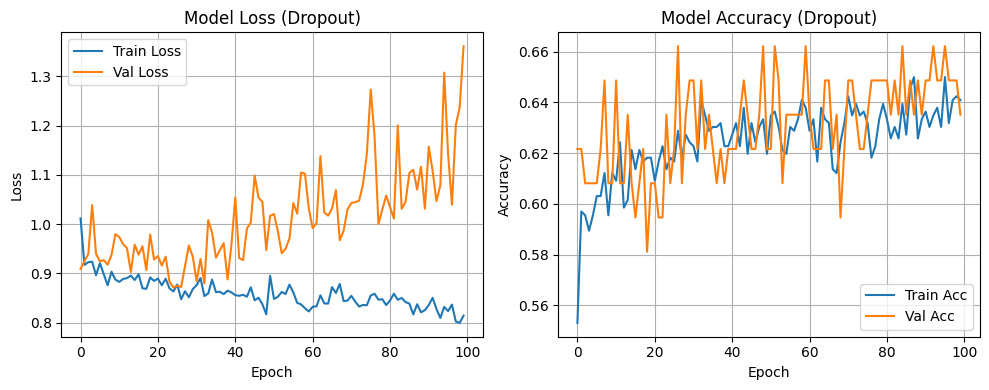

In [ ]:
# @title Exercise 3B: Visualize Effects of Dropout

import matplotlib.pyplot as plt

# Print title
print("Exercise 3B: Visualize Effects of Dropout")

# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# ------------------------------------------------------------------
# Plot 1: Loss (Left Graph)
# ------------------------------------------------------------------
ax1.plot(ex_history['loss'], label='Train Loss')
ax1.plot(ex_history['val_loss'], label='Val Loss')
ax1.set_title('Model Loss (Dropout)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# ------------------------------------------------------------------
# Plot 2: Accuracy (Right Graph)
# ------------------------------------------------------------------
ax2.plot(ex_history['accuracy'], label='Train Acc')
ax2.plot(ex_history['val_accuracy'], label='Val Acc')
ax2.set_title('Model Accuracy (Dropout)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

If the code is correct you should see something _similar_ to these plots.

![__](https://biologicslab.co:/BIO1173/images/class_02/class_02_3_image06A.png)



### **Comparative Analysis: Dropout (Exercise 3A) vs. Baseline (Exercise 1A)**

This comparison highlights how **Dropout** functions on the Heart Disease dataset. While it doesn't create the perfect "inverted" graph seen in the Obesity example, it significantly dampens the catastrophic overfitting seen in the baseline.

##### **1. Model Loss (Left Plot)**
* **Exercise 1A (Baseline - Image 02E):**
    * **Behavior:** Total divergence. The Training Loss drops to ~0.5, while Validation Loss skyrockets to **>3.0**.
    * **Diagnosis:** The model is completely memorizing the training data.
* **Exercise 3A (Dropout - Image 07E):**
    * **Behavior:** The divergence is **constrained**. The Validation Loss starts low but rises to **~1.2**.
    * **Comparison:** While the Validation Loss is still increasing (indicating the model is struggling to generalize perfectly), Dropout has prevented the massive explosion seen in 1A. The gap between Train and Validation is much smaller.

##### **2. Model Accuracy (Right Plot)**
* **Exercise 1A (Baseline - Image 02E):**
    * **Behavior:** Training Accuracy climbs to **~77%**, but Validation Accuracy crashes to **~50%**.
    * **Diagnosis:** The model's "knowledge" is useless on new data.
* **Exercise 3A (Dropout - Image 07E):**
    * **Behavior:** Training and Validation Accuracy are tightly coupled.
    * **Training:** Reaches ~64%.
    * **Validation:** Hovers around **64-65%**.
    * **Observation:** The model is no longer hallucinating high accuracy. By dropping neurons, the training accuracy has been forced down (from 77% to 64%), but the validation accuracy has stabilized and is actually performing *better* than the baseline (64% vs 50%).

##### **Summary Table**

| Metric | Exercise 1A (None) | Exercise 3A (Dropout) | Conclusion |
| :--- | :--- | :--- | :--- |
| **Peak Val Loss** | **~3.5** (Explosion) | **~1.2** (Rising) | Dropout reduced error magnitude by ~65%. |
| **Val Accuracy** | **~50%** (Random) | **~64%** (Stable) | Dropout improved real-world performance. |
| **Diagnosis** | Total Failure | **Stabilized** | The model is now stable, though likely needs further tuning (e.g., higher dropout rate or simpler architecture) to reduce the rising loss further. |

## **Batch Normalization**

**Batch Normalization (BatchNorm)** is a technique introduced in 2015 by Ioffe and Szegedy that addresses one of the most difficult problems in training deep neural networks: **Internal Covariate Shift**. While primarily designed to speed up training, it also acts as a powerful regularizer that helps reduce overfitting.

##### **The Problem: Internal Covariate Shift**
As a neural network trains, the weights in the early layers change. This changes the distribution of the data (the "covariate") fed into the subsequent layers.
* **The Consequence:** The deeper layers are constantly trying to adapt to a "moving target." They have to re-adjust not just to the errors, but to the changing input distribution from the previous layer.
* **The Result:** Training is slow, unstable, and requires very small learning rates.

##### **The Solution: Normalize Every Layer**
Batch Normalization solves this by forcing the inputs of a layer to have a mean of 0 and a variance of 1. It does this by normalizing the data using the statistics (mean and standard deviation) of the current **mini-batch**.

After normalizing, the layer applies two learnable parameters, $\gamma$ (scale) and $\beta$ (shift), so the network can "undo" the normalization if it decides that the raw data was actually better.

##### **How Batch Normalization Reduces Overfitting**
Although BatchNorm was designed for speed, it has a side effect that functions like **Regularization**:

1.  **Noise Injection:** Because the mean and variance are calculated based on a small *random* batch of data (e.g., 32 samples) rather than the entire dataset, there is statistical noise in these estimates.
2.  **Regularization Effect:** This noise prevents the specific weights of a hidden neuron from becoming hyper-sensitive to a specific input sample. The neuron must learn to work with the data regardless of how it is scaled by the rest of the batch.
3.  **Result:** This slight randomization (similar to Dropout, but less aggressive) discourages the network from memorizing the training data.

##### **PyTorch Implementation**
In PyTorch, you use `nn.BatchNorm1d` (for standard feedforward networks) or `nn.BatchNorm2d` (for images/CNNs).

**Key Rules:**
1.  **Placement:** It is typically placed **after** the linear layer but **before** the activation function (Linear $\rightarrow$ BatchNorm $\rightarrow$ ReLU).
2.  **Train/Eval Modes:** Like Dropout, BatchNorm behaves differently during training and validation.
    * **`model.train()`:** It calculates the mean/std from the current batch.
    * **`model.eval()`:** It uses a "running average" of mean/std that it learned during training. **You must switch to eval mode for validation, or your results will be wrong.**


### Example 4A: Batch Normalization

While the data loading and loop structures are nearly identical, **Example 4A** introduces structural changes to the neural network to implement Batch Normalization.

##### **1. Model Architecture (Section 7)**
To add Batch Normalization to the neural network, a specific normalization layer is inserted into the network's architecture.

* **In `__init__`:** We define the Batch Norm layer using `nn.BatchNorm1d`.
    * *Note:* We use `1d` because our data is a flat vector of numbers. If we were processing images, we would use `2d`.
    * *Parameter:* The argument `32` matches the number of neurons in the preceding layer.
* **In `forward`:** The standard order of operations is applied: **Linear Layer $\rightarrow$ Batch Norm $\rightarrow$ Activation**.

**Difference in Code:**

The following code is used to change the architecture of the neural network to incorporate batch normalization:

```text
class ObesityNetBN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ObesityNetBN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        
        # --- ADDED IN EXAMPLE 4A ---
        self.bn1 = nn.BatchNorm1d(32)
        # ---------------------------
        
        self.relu = nn.ReLU()
        self.output = nn.Linear(32, output_dim)

    def forward(self, x):
        x = self.layer1(x)
        
        # --- ADDED IN EXAMPLE 4A ---
        x = self.bn1(x)  # Normalize the linear output
        # ---------------------------
        
        x = self.relu(x) # Apply activation to normalized data
        x = self.output(x)
        return x
```


In [ ]:
# Example 4A: Batch Normalization

# -------------------------------------------------------------------
# 0️⃣  Imports
# -------------------------------------------------------------------
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# -------------------------------------------------------------------
# 1️⃣  Parameters
# -------------------------------------------------------------------
EPOCHS        = 100
VERBOSE       = 0
LEARNING_RATE = 0.05
BATCH_SIZE    = 32

# Print title
print("Example 4A: Batch Normalization")

# Set Seed
seed_value = 1984
set_seeds(seed_value)

# Set device
device = torch.device("cpu")
print(f"Using device: {device}")

# -------------------------------------------------------------------
# 2️⃣  Load data
# -------------------------------------------------------------------
eg_df = pd.read_csv(
    "https://biologicslab.co/BIO1173/data/ObesityDataSet.csv",
    na_values=['NA','?']
)

# -------------------------------------------------------------------
# 3️⃣  Target (Y-values)
# -------------------------------------------------------------------
eg_target_col = "NObeyesdad"
le = LabelEncoder()
eg_df[eg_target_col] = le.fit_transform(eg_df[eg_target_col])

eg_X = eg_df.drop(columns=[eg_target_col])
eg_y = eg_df[eg_target_col].astype('int32')

# -------------------------------------------------------------------
# 4️⃣  Train–Validation–Test Split
# -------------------------------------------------------------------
eg_X_temp, eg_X_test, eg_y_temp, eg_y_test = train_test_split(
    eg_X, eg_y, test_size=0.2, random_state=42, stratify=eg_y
)

eg_X_train, eg_X_val, eg_y_train, eg_y_val = train_test_split(
    eg_X_temp, eg_y_temp, test_size=0.1, random_state=42, stratify=eg_y_temp
)

# -------------------------------------------------------------------
# 5️⃣  Preprocessing
# -------------------------------------------------------------------
categorical_cols = [c for c in eg_X.columns if eg_X[c].dtype == "object"]
numeric_cols     = [c for c in eg_X.columns if c not in categorical_cols]

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler",  StandardScaler())
    ]), numeric_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(drop="if_binary", sparse_output=False))
    ]), categorical_cols)
])

# Fit & transform training data
eg_X_train_proc = preprocessor.fit_transform(eg_X_train).astype(np.float32)
eg_X_val_proc   = preprocessor.transform(eg_X_val).astype(np.float32)
eg_X_test_proc  = preprocessor.transform(eg_X_test).astype(np.float32)

eg_y_train = eg_y_train.to_numpy().astype(np.int32).reshape(-1)
eg_y_val   = eg_y_val.to_numpy().astype(np.int32).reshape(-1)
eg_y_test  = eg_y_test.to_numpy().astype(np.int32).reshape(-1)

# -------------------------------------------------------------------
# 6️⃣  Convert to PyTorch Tensors & DataLoaders
# -------------------------------------------------------------------
eg_X_train_t = torch.tensor(eg_X_train_proc).to(device)
eg_X_val_t   = torch.tensor(eg_X_val_proc).to(device)
eg_X_test_t  = torch.tensor(eg_X_test_proc).to(device)

eg_y_train_t = torch.tensor(eg_y_train, dtype=torch.long).to(device)
eg_y_val_t   = torch.tensor(eg_y_val, dtype=torch.long).to(device)
eg_y_test_t  = torch.tensor(eg_y_test, dtype=torch.long).to(device)

eg_train_dataset = TensorDataset(eg_X_train_t, eg_y_train_t)
eg_val_dataset   = TensorDataset(eg_X_val_t, eg_y_val_t)

eg_train_loader = DataLoader(eg_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
eg_val_loader   = DataLoader(eg_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# -------------------------------------------------------------------
# 7️⃣  Build Model with Batch Normalization
# -------------------------------------------------------------------
n_classes = len(np.unique(eg_y_train))
input_dim = eg_X_train_proc.shape[1]

class ObesityNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ObesityNet, self).__init__()

        # Hidden Layer
        self.layer1 = nn.Linear(input_dim, 32)

        # Batch Norm Layer (32 features coming from layer1)
        # 1D is used for Dense/Linear layers
        self.bn1 = nn.BatchNorm1d(32)

        self.relu = nn.ReLU()

        # Output Layer
        self.output = nn.Linear(32, output_dim)

    def forward(self, x):
        # Order: Linear -> BatchNorm -> ReLU
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.output(x)
        return x

eg_model = ObesityNet(input_dim, n_classes).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(eg_model.parameters(), lr=LEARNING_RATE)

# -------------------------------------------------------------------
# 8️⃣  Train model
# -------------------------------------------------------------------
print(f"------Training Starting for {EPOCHS} epochs --------------")
start_time = time.time()

eg_history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

for epoch in range(EPOCHS):
    # --- Training Phase ---
    # Important: eg_model.train() tells BN to use batch statistics
    eg_model.train()
    train_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in eg_train_loader:
        optimizer.zero_grad()
        outputs = eg_model(X_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    avg_train_loss = train_loss / len(eg_train_loader)
    train_acc = correct / total

    # --- Validation Phase ---
    # Important: eg_model.eval() tells BN to use running stats (not batch stats)
    eg_model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in eg_val_loader:
            outputs = eg_model(X_batch)
            loss = loss_fn(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    avg_val_loss = val_loss / len(eg_val_loader)
    val_acc = correct / total

    # Store metrics
    eg_history['accuracy'].append(train_acc)
    eg_history['val_accuracy'].append(val_acc)
    eg_history['loss'].append(avg_train_loss)
    eg_history['val_loss'].append(avg_val_loss)

    if VERBOSE > 0:
        print(
            f"Epoch {epoch+1}/{EPOCHS} - "
            f"loss: {avg_train_loss:.4f} - "
            f"acc: {train_acc:.4f} - "
            f"val_loss: {avg_val_loss:.4f} - "
            f"val_acc: {val_acc:.4f}"
        )
# ---------------------------------------------------------------------------
# 9️⃣ Inspect training
# ---------------------------------------------------------------------------
print(f"\nTraining finished")
print("Best val accuracy:", max(eg_history["val_accuracy"]))
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Example 4A: Batch Normalization
✅ Seeds set to: 1984
Using device: cpu
------Training Starting for 100 epochs --------------

Training finished
Best val accuracy: 0.9349112426035503
Elapsed time: 0:00:17.19


If the code is correct, you should see something _similar_ to the following output:
```text
Example 4A: Batch Normalization
✅ Seeds set to: 1984
Using device: cpu
------Training Starting for 100 epochs --------------

Training finished
Best val accuracy: 0.9349112426035503
Elapsed time: 0:00:17.19
```

### Example 4B: Visualize Effects of Batch Normalization

The code in the cell below is **exactly** the same as that used in `Example 1B` except the axis titles have been changed to specify the type of overfitting protection that was used.

# Example 4B: Visualize Effects of Batch Normalization


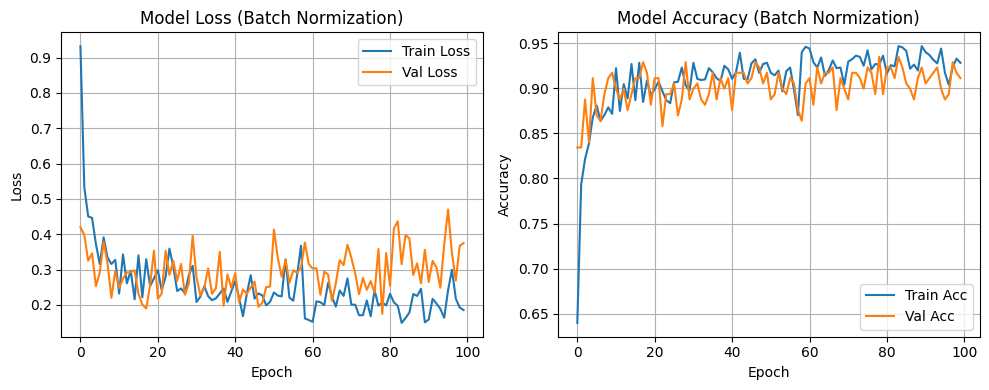

In [ ]:
# Example 4B: Visualize Effects of Batch Normalization

import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))


# Print title
print("# Example 4B: Visualize Effects of Batch Normalization")

# ------------------------------------------------------------------
# Plot 1: Loss (Left Graph)
# ------------------------------------------------------------------
ax1.plot(eg_history['loss'], label='Train Loss')
ax1.plot(eg_history['val_loss'], label='Val Loss')
ax1.set_title('Model Loss (Batch Normization)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# ------------------------------------------------------------------
# Plot 2: Accuracy (Right Graph)
# ------------------------------------------------------------------
ax2.plot(eg_history['accuracy'], label='Train Acc')
ax2.plot(eg_history['val_accuracy'], label='Val Acc')
ax2.set_title('Model Accuracy (Batch Normization)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

If the code is correct you should see something _similar_ to these plots.

![__](https://biologicslab.co:/BIO1173/images/class_02/class_02_3_image07A.png)


### **Comparative Analysis: Batch Normalization (Example 4A) vs. Baseline (Example 1A)**

This comparison highlights a distinct characteristic of Batch Normalization: **Noise Injection**. While L2 Regularization smoothes the curves and Dropout inverts them, Batch Normalization often makes the training dynamics more volatile (jagged) while preventing pure memorization.

##### **1. Model Loss (Left Plot)**
* **Example 1A (Baseline - Image 01E):**
    * **Behavior:** The Training Loss dropped smoothly to nearly **0**.
    * **Stability:** After the initial drop, the curves were relatively smooth, indicating the model settled into a specific solution (memorization).
* **Example 4A (Batch Norm - Image 09E):**
    * **Behavior:** The Training Loss does **not** reach 0; it hovers around **0.15**.
    * **Volatility:** The lines are extremely **jagged/spiky**.
    * **Diagnosis:** This is the "Noise Injection" property of Batch Normalization in action. Because the model effectively sees slightly different data statistics in every batch, it cannot easily settle into a perfect memorization state. The loss remains higher because the model is constantly being forced to readjust.

##### **2. Model Accuracy (Right Plot)**
* **Example 1A (Baseline):**
    * **Behavior:** The model achieved **100%** Training Accuracy and **~96%** Validation Accuracy.
    * **Diagnosis:** Perfect memorization.
* **Example 4A (Batch Norm - Image 09E):**
    * **Behavior:** The Training Accuracy is capped at **~94%**, and Validation Accuracy hovers around **90-91%**.
    * **Diagnosis:** Batch Normalization successfully prevented the model from reaching 100% training accuracy (memorization).

##### **Key Takeaway**
In this specific dataset, Batch Normalization acted as a very aggressive regularizer.
* **The Trade-off:** While it successfully stopped the "perfect memorization" seen in Example 1A, the injected noise reduced the peak validation accuracy slightly (from ~96% to ~91%).
* **When to use it:** This "jagged" behavior often stabilizes on larger datasets or with larger batch sizes. On smaller datasets (like this one), the statistical noise from small batches can sometimes be too aggressive, as seen in the volatility of the orange line.

### **Exercise 4A: Batch Normalization**

Follow these step-by-step instructions to convert your Exercise 1A code (without batch normalization) into Exercise 4A code (with batch normalization).

---
##### **Step 1: Set the seed value**

set the `seed_value` = 2001

##### **Step 2: Modify the Model Class to Include Batch Normalization**

**Location:** Section 7️⃣ Build Model & Optimizer (around line 109)

**Original code:**

    class HeartDiseaseNet(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(HeartDiseaseNet, self).__init__()
            self.layer1 = nn.Linear(input_dim, 32)
            self.relu = nn.ReLU()
            self.output = nn.Linear(32, output_dim)
            # Note: No Softmax here. CrossEntropyLoss expects raw logits.

        def forward(self, x):
            x = self.relu(self.layer1(x))
            x = self.output(x)
            return x

**New code:**

    class HeartDiseaseNet(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(HeartDiseaseNet, self).__init__()
            # Hidden Layer
            self.layer1 = nn.Linear(input_dim, 32)
            # Batch Norm Layer (32 features coming from layer1)
            self.bn1 = nn.BatchNorm1d(32)
            self.relu = nn.ReLU()
            # Output Layer
            self.output = nn.Linear(32, output_dim)

        def forward(self, x):
            # Order: Linear -> BatchNorm -> ReLU
            x = self.layer1(x)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.output(x)
            return x

**Why:**
- Added nn.BatchNorm1d(32) layer to normalize the outputs from layer1
- The number 32 matches the output size of layer1
- Modified forward method to apply batch normalization between the linear layer and activation
- Standard order is: Linear -> BatchNorm -> Activation

---

##### **Summary of Changes**

1. Set the `seed_value` = 2001
2. Added self.bn1 = nn.BatchNorm1d(32) in the __init__ method
3. Modified the forward method to apply batch normalization
4. Changed the order of operations to: Linear -> BatchNorm -> ReLU -> Output

---

##### **What Batch Normalization Does**

**Batch Normalization** is a technique that normalizes the inputs to each layer, providing several benefits:

**Benefits:**
- **Faster training:** Allows higher learning rates and faster convergence
- **Reduces internal covariate shift:** Stabilizes the distribution of layer inputs during training
- **Regularization effect:** Provides some regularization, reducing the need for dropout
- **Less sensitive to initialization:** Makes the network less dependent on careful weight initialization
- **Improves gradient flow:** Helps prevent vanishing/exploding gradients

**How it works:**
1. For each mini-batch, compute the mean and variance of the layer outputs
2. Normalize the outputs to have zero mean and unit variance
3. Apply learnable scale (gamma) and shift (beta) parameters
4. During training: uses batch statistics
5. During evaluation: uses running statistics accumulated during training

---

##### **Understanding `BatchNorm1d`**

The BatchNorm1d layer requires one parameter: the number of features to normalize.

    self.bn1 = nn.BatchNorm1d(32)

- **32** is the number of features (output size of the previous linear layer)
- BatchNorm1d is used for 1D data (like in fully connected networks)
- For convolutional networks, you would use BatchNorm2d

---

##### **Layer Order: Why Linear -> BatchNorm -> Activation?**

The standard and most common order is:

    Linear -> BatchNorm -> Activation

**Why this order?**
1. **Normalizes pre-activations:** Batch norm normalizes the linear outputs before applying the activation function
2. **Empirically better:** Research shows this order generally works best
3. **Prevents saturation:** Helps activation functions (like ReLU) work in their optimal range

**Alternative order (less common):**
- Linear -> Activation -> BatchNorm (works but generally less effective)

---

##### **Training vs Evaluation Modes**

Batch normalization behaves differently during training and evaluation:

**Training mode (model.train()):**
- Uses statistics (mean/variance) from the current mini-batch
- Updates running statistics for use during evaluation
- Adds some noise due to batch-level statistics (provides regularization)

**Evaluation mode (model.eval()):**
- Uses accumulated running statistics (computed during training)
- Provides consistent, deterministic outputs
- No noise added

PyTorch automatically handles this switching through model.train() and model.eval().

---

#### **Important Notes**

**No additional parameters needed:** Unlike dropout or L2 regularization, batch normalization doesn't require a hyperparameter to tune.

**Automatic behavior:** The code already includes model.train() and model.eval() calls, so batch normalization will automatically:
- Use batch statistics during training
- Use running statistics during validation/testing

**Learnable parameters:** Batch normalization adds two learnable parameters per feature:
- **Gamma (scale):** Allows the network to scale the normalized values
- **Beta (shift):** Allows the network to shift the normalized values
- These are learned during training through backpropagation

---

##### **Where to Place Batch Normalization**

In this exercise, batch normalization is placed after the linear layer and before the activation:

    Linear(input_dim, 32) -> BatchNorm1d(32) -> ReLU() -> Linear(32, output_dim)

**For deeper networks:**
- Add batch normalization after each linear/convolutional layer
- Place before the activation function (most common)
- Don't add batch norm before the output layer (usually)

**Example for a deeper network:**

    Linear -> BatchNorm -> ReLU -> Linear -> BatchNorm -> ReLU -> Output

---

#### **Quick Checklist**

Before running your code, verify you have made these changes:

- Step 1: Added self.bn1 = nn.BatchNorm1d(32) in the __init__ method
- Step 1: Modified forward method to apply batch normalization
- Step 1: Ensured order is Linear -> BatchNorm -> ReLU

Once you've completed the step, run your code and compare the results to Exercise 1A!

---

##### **Expected Behavior**

When you run this code with batch normalization:
- **Training may converge faster:** You might reach good accuracy in fewer epochs
- **More stable training:** Loss curves should be smoother
- **Potentially better accuracy:** Both training and validation accuracy may improve
- **Slight regularization effect:** May see reduced overfitting
- **Faster per-epoch training:** Modern GPUs are highly optimized for batch normalization

**Comparison to Exercise 1A:**
- Training should be more stable with less fluctuation in metrics
- The model may reach higher validation accuracy
- You might be able to use higher learning rates successfully

---

##### **Batch Normalization Statistics**

Behind the scenes, BatchNorm1d maintains:
- **running_mean:** Exponential moving average of batch means
- **running_var:** Exponential moving average of batch variances
- **num_batches_tracked:** Counter of batches seen during training

These statistics are automatically updated during training and used during evaluation.

---

##### **Additional Information**

**Batch size considerations:**
- Batch normalization works best with larger batch sizes (32 or more)
- Very small batch sizes (< 8) may have unstable batch statistics
- Current BATCH_SIZE = 32 is appropriate for batch normalization

**When batch normalization may not help:**
- Very small datasets (< 100 samples)
- When batch size is very small (< 8)
- For some recurrent architectures (use LayerNorm instead)

For this heart disease dataset and configuration, batch normalization should work well!


In [ ]:
# @title Exercise 4A: Batch Normalization

# ------------------------------------------------------------
# 0️⃣  Imports
# ------------------------------------------------------------
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ------------------------------------------------------------
# 1️⃣  Parameters
# ------------------------------------------------------------
EPOCHS        = 100
PATIENCE      = 10
VERBOSE       = 0     # 0 means no output during training
LEARNING_RATE = 0.05
BATCH_SIZE    = 32

# Print title
print("Exercise 4A: Batch Normalization")

# Set Seed
seed_value = 2001
set_seeds(seed_value)

# Set device to CPU
device = torch.device("cpu")
print(f"Using device: {device}")

# ------------------------------------------------------------
# 2️⃣  Load data
# ------------------------------------------------------------
ex_df = pd.read_csv("https://biologicslab.co/BIO1173/data/heart_disease.csv",
                    na_values=['NA','?'])
# ------------------------------------------------------------
# 3️⃣  Target (Y-values)
# ------------------------------------------------------------
ex_target_col = "RestingECG"
le = LabelEncoder()
ex_df[ex_target_col] = le.fit_transform(ex_df[ex_target_col])

ex_X = ex_df.drop(columns=[ex_target_col])
ex_y = ex_df[ex_target_col].astype('int32')

# ------------------------------------------------------------
# 4️⃣  Train–Validation–Test Split
# ------------------------------------------------------------
# First split into train+val and test
ex_X_temp, ex_X_test, ex_y_temp, ex_y_test = train_test_split(
    ex_X, ex_y, test_size=0.2, random_state=42, stratify=ex_y)

# Then split train+val into train and val
ex_X_train, ex_X_val, ex_y_train, ex_y_val = train_test_split(
    ex_X_temp, ex_y_temp, test_size=0.1, random_state=42, stratify=ex_y_temp)

# ------------------------------------------------------------
# 5️⃣  Preprocessing
# ------------------------------------------------------------
categorical_cols = [c for c in ex_X.columns if ex_X[c].dtype == "object"]
numeric_cols     = [c for c in ex_X.columns if c not in categorical_cols]

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler",  StandardScaler())
    ]), numeric_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(drop="if_binary", sparse_output=False))
    ]), categorical_cols)
])

# Convert data to correct numeric type (Numpy arrays)
ex_X_train_proc = preprocessor.fit_transform(ex_X_train).astype(np.float32)
ex_X_val_proc   = preprocessor.transform(ex_X_val).astype(np.float32)
ex_X_test_proc  = preprocessor.transform(ex_X_test).astype(np.float32)

ex_y_train = ex_y_train.to_numpy().astype(np.int32).reshape(-1)
ex_y_val   = ex_y_val.to_numpy().astype(np.int32).reshape(-1)
ex_y_test  = ex_y_test.to_numpy().astype(np.int32).reshape(-1)

# ------------------------------------------------------------
# 6️⃣  Convert to PyTorch Tensors & DataLoaders
# ------------------------------------------------------------
# Convert Features to Float Tensors
ex_X_train_t = torch.tensor(ex_X_train_proc).to(device)
ex_X_val_t   = torch.tensor(ex_X_val_proc).to(device)
ex_X_test_t  = torch.tensor(ex_X_test_proc).to(device)

# Convert Targets to Long Tensors (Required for CrossEntropyLoss)
ex_y_train_t = torch.tensor(ex_y_train, dtype=torch.long).to(device)
ex_y_val_t   = torch.tensor(ex_y_val, dtype=torch.long).to(device)
ex_y_test_t  = torch.tensor(ex_y_test, dtype=torch.long).to(device)

# Create DataLoaders for batching
ex_train_dataset = TensorDataset(ex_X_train_t, ex_y_train_t)
ex_val_dataset   = TensorDataset(ex_X_val_t, ex_y_val_t)

ex_train_loader = DataLoader(ex_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
ex_val_loader   = DataLoader(ex_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# -------------------------------------------------------------------
# 7️⃣  Build Model with Batch Normalization
# -------------------------------------------------------------------
n_classes = len(np.unique(ex_y_train))
input_dim = ex_X_train_proc.shape[1]

class HeartDiseaseNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(HeartDiseaseNet, self).__init__()
        # Hidden Layer
        self.layer1 = nn.Linear(input_dim, 32)
        # Batch Norm Layer (32 features coming from layer1)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        # Output Layer
        self.output = nn.Linear(32, output_dim)

    def forward(self, x):
        # Order: Linear -> BatchNorm -> ReLU
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.output(x)
        return x

ex_model = HeartDiseaseNet(input_dim, n_classes).to(device)

# Define Loss and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(ex_model.parameters(), lr=LEARNING_RATE)

# ------------------------------------------------------------
# 8️⃣  Train model (Manual Loop)
# ------------------------------------------------------------
print(f"------Training Starting for {EPOCHS} epochs --------------")
start_time = time.time()

# Dictionary to store history
ex_history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

for epoch in range(EPOCHS):
    # --- Training Phase ---
    ex_model.train()
    train_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in ex_train_loader:
        optimizer.zero_grad()               # Reset gradients
        outputs = ex_model(X_batch)         # Forward pass
        loss = loss_fn(outputs, y_batch)    # Calculate loss
        loss.backward()                     # Backward pass
        optimizer.step()                    # Update weights

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    avg_train_loss = train_loss / len(ex_train_loader)
    train_acc = correct / total

    # --- Validation Phase ---
    ex_model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad(): # No gradient needed for validation
        for X_batch, y_batch in ex_val_loader:
            outputs = ex_model(X_batch)
            loss = loss_fn(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    avg_val_loss = val_loss / len(ex_val_loader)
    val_acc = correct / total

    # Store metrics
    ex_history['accuracy'].append(train_acc)
    ex_history['val_accuracy'].append(val_acc)
    ex_history['loss'].append(avg_train_loss)
    ex_history['val_loss'].append(avg_val_loss)

    # Verbose print
    if VERBOSE > 0:
        print(
            f"Epoch {epoch+1}/{EPOCHS} - "
            f"loss: {avg_train_loss:.4f} - "
            f"acc: {train_acc:.4f} - "
            f"val_loss: {avg_val_loss:.4f} - "
            f"val_acc: {val_acc:.4f}"
        )

# ---------------------------------------------------------------------------
# 9️⃣ Inspect training
# ---------------------------------------------------------------------------
print(f"\nTraining finished")
print("Best val accuracy:", max(ex_history["val_accuracy"]))
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Exercise 4A: Batch Normalization
✅ Seeds set to: 2001
Using device: cpu
------Training Starting for 100 epochs --------------

Training finished
Best val accuracy: 0.6351351351351351
Elapsed time: 0:00:04.63


If the code is correct you should see something _similar_ to the following output:
```text
Exercise 4A: Batch Normalization
✅ Seeds set to: 2001
Using device: cpu
------Training Starting for 100 epochs --------------

Training finished
Best val accuracy: 0.6351351351351351
Elapsed time: 0:00:04.63
```

### **Exercise 4B: Visualize the Effects of Batch Normalization**

`Copy-and-paste` the code from **`Exercise 1B`** into the cell below. Change the titles of axis 1 and axis 2 to read "Batch Normalization").

Exercise 4B: Visualize the Effects of Batch Normalization


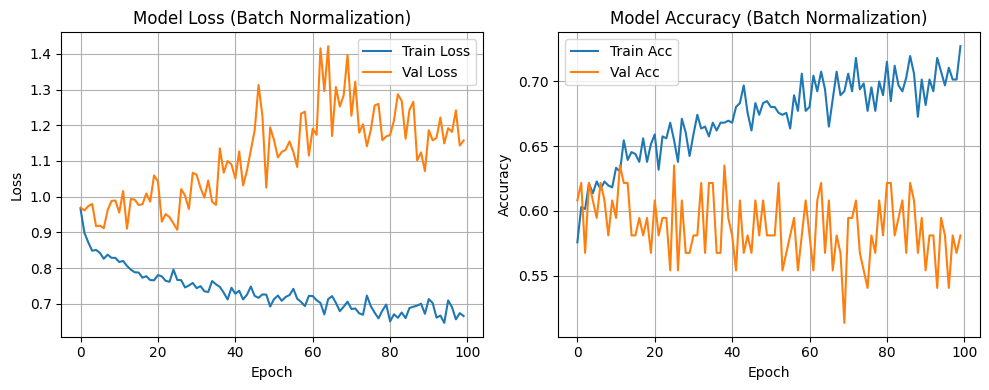

In [ ]:
# @title Exercise 4B: Visualize the Effects of Batch Normalization

import matplotlib.pyplot as plt

# Print title
print("Exercise 4B: Visualize the Effects of Batch Normalization")

# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# ------------------------------------------------------------------
# Plot 1: Loss (Left Graph)
# ------------------------------------------------------------------
ax1.plot(ex_history['loss'], label='Train Loss')
ax1.plot(ex_history['val_loss'], label='Val Loss')
ax1.set_title('Model Loss (Batch Normalization)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# ------------------------------------------------------------------
# Plot 2: Accuracy (Right Graph)
# ------------------------------------------------------------------
ax2.plot(ex_history['accuracy'], label='Train Acc')
ax2.plot(ex_history['val_accuracy'], label='Val Acc')
ax2.set_title('Model Accuracy (Batch Normalization)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


If the code is correct you should see something _similar_ to these plots.

![__](https://biologicslab.co:/BIO1173/images/class_02/class_02_3_image08A.png)


### **Comparative Analysis: Batch Normalization (Exercise 4A) vs. Baseline (Exercise 1A)**

This comparison illustrates how Batch Normalization affects model training on the `RestingECG` prediction task. Similar to the previous examples, it acts as a regularizer, though the effects on this specific dataset are nuanced.

##### **1. Model Loss (Left Plot)**
* **Exercise 1A (Baseline - Image 02E):**
    * **Behavior:** Catastrophic failure. The Validation Loss (Orange) diverges almost immediately and skyrockets to **>3.0**.
    * **Diagnosis:** Complete memorization of training data with no ability to generalize.
* **Exercise 4A (Batch Norm - Image 10E):**
    * **Behavior:** The Validation Loss rises to **~1.3** by Epoch 100.
    * **Comparison:** While the loss is still rising (indicating some overfitting is still occurring), Batch Normalization successfully **dampened the explosion**. It reduced the peak error by more than 50% compared to the baseline.
    * **Dynamics:** Notice the training loss (Blue) flattens out around 0.7 rather than dropping to 0.5 like the baseline. This confirms that Batch Norm is making it harder for the model to "cheat" and memorize the training set.

##### **2. Model Accuracy (Right Plot)**
* **Exercise 1A (Baseline - Image 02E):**
    * **Behavior:** Validation accuracy collapses to **~50%**, which is effectively random guessing for this task.
    * **Stability:** Highly unstable.
* **Exercise 4A (Batch Norm - Image 10E):**
    * **Behavior:** Validation accuracy fluctuates between **50% and 60%**.
    * **Comparison:** While not a "solved" problem (accuracy is still low), the model with Batch Normalization performs consistently better than the baseline. It avoids the complete collapse seen in 1A.

##### **Summary Table**

| Metric | Exercise 1A (None) | Exercise 4A (Batch Norm) | Conclusion |
| :--- | :--- | :--- | :--- |
| **Peak Val Loss** | **~3.5** | **~1.3** | Batch Norm significantly reduced the magnitude of overfitting errors. |
| **Val Accuracy** | **~50%** (Random) | **~55-60%** (Slight Gain) | The model is more stable but struggles to learn high-quality features from this small dataset. |
| **Overall** | **Total Failure** | **Stabilized Failure** | Batch Norm prevented the worst of the overfitting but didn't miraculously solve the problem. This suggests the model might need **stronger regularization** (like higher Dropout) or more data. |

# **Early Stopping in PyTorch to Prevent Overfitting**

Now that we have established baselines in `Example 1` and in **`Exercise 1`** that **overfitting** occurs, we will now examine techniques that can be used to control overfitting. In **`Example 5`**, we will look at **`Early Stopping`**.

It can be difficult to determine exactly how many epochs to cycle through to optimally train a neural network. **_Overfitting_** will occur if you train the neural network for too many epochs; the model will begin to memorize the training set and will not perform well on **new data**, despite attaining a high accuracy during training.

Overfitting occurs when a neural network is trained to the point that it begins to **memorize rather than generalize**, as demonstrated in this figure.

![Training vs. Validation Error for Overfitting](https://biologicslab.co/BIO1173/images/class_02/class_3_training_val.png "Training vs. Validation Error for Overfitting")
**Training vs. Validation Error for Overfitting**

### **Implementation in PyTorch**
Unlike Keras, which provides a built-in callback for this, **PyTorch** requires us to implement Early Stopping logic manually within the training loop. This generally involves:
1.  **Monitoring** the Validation Loss after every epoch.
2.  **Saving** the model weights whenever the Validation Loss improves (decreases).
3.  **Stopping** the training loop if the Validation Loss has not improved for a set number of epochs (a parameter often called `patience`).

It is important to segment the original dataset into several datasets to support this process:

* **Training Set**
* **Validation Set**
* **Holdout Set**

You can construct these sets in several different ways. The following code blocks demonstrate the standard approach.

The most common method uses a **`training`** and **`validation set`**. We use the `training data` to train the neural network and the `validation set` to determine when to stop. This attempts to halt training at the "sweet spot" before the validation error begins to rise.

This method will only give accurate "out of sample" predictions for the `validation set`; this is usually 20% of the data. The predictions for the training data will be overly optimistic, as these were the data that we used to train the neural network.

This figure demonstrates how we divide the dataset.

![Training with a Validation Set](https://biologicslab.co/BIO1173/images/class_02/class_1_train_val.png "Training with a Validation Set")

**Training with a Validation Set**

### Example 5A: Early Stopping

Adding Early Stopping fundamentally changes the **Training Loop**. Instead of blindly running for 100 epochs, it now includes logic to monitor performance, adjust learning rates, and stop training automatically.

##### **1. New Parameters (Section 1)**
Example 5A adds a parameter to define how long the model should wait for improvement before giving up.
* **Code Change:**
    ```python
    PATIENCE = 10  # Stop if no improvement after 10 epochs
    ```

##### **2. Learning Rate Scheduler (Section 7)**
Example 5A introduces a **Scheduler**. This is often used alongside Early Stopping to squeeze out a bit more performance before stopping.
* **Code Change:** `optim.lr_scheduler.ReduceLROnPlateau` is added.
* **Function:** If the validation accuracy stalls, it reduces the learning rate (by half in this code) to help the model fine-tune its weights.

##### **3. Early Stopping Logic (Section 8 - Inside Loop)**
In Example 1A, the loop simply ran `for epoch in range(EPOCHS)`. In Example 5A, a sophisticated check is added at the end of every epoch:

1.  **Check Improvement:** It compares the current `val_acc` to the `best_val_acc` seen so far.
2.  **Save Best Model:** If the current model is the best, it saves the weights immediately using `torch.save()`.
    ```python
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(eg_model.state_dict(), checkpoint_path) # <--- CRITICAL
        patience_counter = 0
    ```
3.  **Trigger Stop:** If performance didn't improve, it increases the `patience_counter`. If the counter hits the limit (`10`), the loop is broken immediately.
    ```python
    if patience_counter >= PATIENCE:
        print(f"Early stopping triggered...")
        break
    ```

##### **4. Restoring the Best Weights (Section 9)**
This is a critical step often missed by beginners.
* **The Problem:** When Early Stopping triggers (e.g., at Epoch 50), the model in memory is the one from Epoch 50. However, because patience was 10, the *best* model was actually from Epoch 40.
* **The Fix:** Example 5A reloads the saved checkpoint at the very end to ensure `eg_model` contains the optimal weights, not the "overfitted" weights that triggered the stop.
    
  ```python
    eg_model.load_state_dict(torch.load(checkpoint_path))
  ```

In [ ]:
# Example 5A: Early Stopping

# ------------------------------------------------------------
# 0️⃣  Imports
# ------------------------------------------------------------
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ------------------------------------------------------------
# 1️⃣  Parameters
# ------------------------------------------------------------
EPOCHS        = 100
PATIENCE      = 10
VERBOSE       = 2     # Set to 1 or 2 to see training progress
LEARNING_RATE = 0.05
BATCH_SIZE    = 32

# Print title
print("Example 5A: Early Stopping")

# Set Seed
seed_value = 1999
set_seeds(seed_value)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ------------------------------------------------------------
# 2️⃣  Load data
# ------------------------------------------------------------
eg_df = pd.read_csv("https://biologicslab.co/BIO1173/data/ObesityDataSet.csv",
                    na_values=['NA','?'])

# ------------------------------------------------------------
# 3️⃣  Target (Y-values)
# ------------------------------------------------------------
eg_target_col = "NObeyesdad"
le = LabelEncoder()
eg_df[eg_target_col] = le.fit_transform(eg_df[eg_target_col])

eg_X = eg_df.drop(columns=[eg_target_col])
eg_y = eg_df[eg_target_col].astype('int32')

# ------------------------------------------------------------
# 4️⃣  Train–Validation–Test Split
# ------------------------------------------------------------
# First split into train+val and test
eg_X_temp, eg_X_test, eg_y_temp, eg_y_test = train_test_split(
    eg_X, eg_y, test_size=0.2, random_state=42, stratify=eg_y)

# Then split train+val into train and val
eg_X_train, eg_X_val, eg_y_train, eg_y_val = train_test_split(
    eg_X_temp, eg_y_temp, test_size=0.1, random_state=42, stratify=eg_y_temp)

# ------------------------------------------------------------
# 5️⃣  Preprocessing
# ------------------------------------------------------------
categorical_cols = [c for c in eg_X.columns if eg_X[c].dtype == "object"]
numeric_cols     = [c for c in eg_X.columns if c not in categorical_cols]

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler",  StandardScaler())
    ]), numeric_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(drop="if_binary", sparse_output=False))
    ]), categorical_cols)
])

# Convert data to correct numeric type (Numpy arrays)
eg_X_train_proc = preprocessor.fit_transform(eg_X_train).astype(np.float32)
eg_X_val_proc   = preprocessor.transform(eg_X_val).astype(np.float32)
eg_X_test_proc  = preprocessor.transform(eg_X_test).astype(np.float32)

eg_y_train = eg_y_train.to_numpy().astype(np.int32).reshape(-1)
eg_y_val   = eg_y_val.to_numpy().astype(np.int32).reshape(-1)
eg_y_test  = eg_y_test.to_numpy().astype(np.int32).reshape(-1)

# ------------------------------------------------------------
# 6️⃣  Convert to PyTorch Tensors & DataLoaders
# ------------------------------------------------------------
eg_X_train_t = torch.tensor(eg_X_train_proc).to(device)
eg_X_val_t   = torch.tensor(eg_X_val_proc).to(device)
eg_X_test_t  = torch.tensor(eg_X_test_proc).to(device)

eg_y_train_t = torch.tensor(eg_y_train, dtype=torch.long).to(device)
eg_y_val_t   = torch.tensor(eg_y_val, dtype=torch.long).to(device)
eg_y_test_t  = torch.tensor(eg_y_test, dtype=torch.long).to(device)

eg_train_dataset = TensorDataset(eg_X_train_t, eg_y_train_t)
eg_val_dataset   = TensorDataset(eg_X_val_t, eg_y_val_t)

eg_train_loader = DataLoader(eg_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
eg_val_loader   = DataLoader(eg_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ------------------------------------------------------------
# 7️⃣  Build Model, Optimizer & Scheduler
# ------------------------------------------------------------
n_classes = len(np.unique(eg_y_train))
input_dim = eg_X_train_proc.shape[1]

class ObesityNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ObesityNet, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.relu = nn.ReLU()
        self.output = nn.Linear(32, output_dim)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.output(x)
        return x

eg_model = ObesityNet(input_dim, n_classes).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(eg_model.parameters(), lr=LEARNING_RATE)

# ReduceLROnPlateau Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
                                                 factor=0.5,
                                                 patience=int(PATIENCE/2))

# ------------------------------------------------------------
# 8️⃣  Train model with Early Stopping
# ------------------------------------------------------------
print(f"-----Training Starting for up to {EPOCHS} epochs --------------------------")
start_time = time.time()

eg_history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

# Variables for Early Stopping
best_val_acc = 0.0
patience_counter = 0
checkpoint_path = "eg_best_classification_model.pth"

for epoch in range(EPOCHS):
    # --- Training Phase ---
    eg_model.train()
    train_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in eg_train_loader:
        optimizer.zero_grad()
        outputs = eg_model(X_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    avg_train_loss = train_loss / len(eg_train_loader)
    train_acc = correct / total

    # --- Validation Phase ---
    eg_model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in eg_val_loader:
            outputs = eg_model(X_batch)
            loss = loss_fn(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    avg_val_loss = val_loss / len(eg_val_loader)
    val_acc = correct / total

    # Update History
    eg_history['accuracy'].append(train_acc)
    eg_history['val_accuracy'].append(val_acc)
    eg_history['loss'].append(avg_train_loss)
    eg_history['val_loss'].append(avg_val_loss)

    # Step Scheduler (monitor val_accuracy)
    scheduler.step(val_acc)

    # Print Progress
    if VERBOSE > 0:
        print(
            f"Epoch {epoch+1}/{EPOCHS} - "
            f"loss: {avg_train_loss:.4f} - "
            f"acc: {train_acc:.4f} - "
            f"val_loss: {avg_val_loss:.4f} - "
            f"val_acc: {val_acc:.4f}"
        )

    # --- Early Stopping & Checkpointing Logic ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0 # Reset counter
        torch.save(eg_model.state_dict(), checkpoint_path) # Save Best Model
        if VERBOSE > 0:
            print(f"  -> Val Acc improved to {val_acc:.4f}. Model saved.")
    else:
        patience_counter += 1
        if VERBOSE > 0:
            print(f"  -> No improvement. Patience: {patience_counter}/{PATIENCE}")

    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

# ---------------------------------------------------------------------------
# 9️⃣ Inspect training & Restore Best Weights
# ---------------------------------------------------------------------------
# Load the best weights back into the model
eg_model.load_state_dict(torch.load(checkpoint_path))
print("\nRestored best model weights.")

print(f"Training finished")
print("Best val accuracy:", max(eg_history["val_accuracy"]))
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Example 5A: Early Stopping
✅ Seeds set to: 1999
Using device: cpu
-----Training Starting for up to 100 epochs --------------------------
Epoch 1/100 - loss: 0.8942 - acc: 0.6359 - val_loss: 0.5034 - val_acc: 0.7988
  -> Val Acc improved to 0.7988. Model saved.
Epoch 2/100 - loss: 0.3573 - acc: 0.8565 - val_loss: 0.3905 - val_acc: 0.8639
  -> Val Acc improved to 0.8639. Model saved.
Epoch 3/100 - loss: 0.2208 - acc: 0.9236 - val_loss: 0.2494 - val_acc: 0.9172
  -> Val Acc improved to 0.9172. Model saved.
Epoch 4/100 - loss: 0.2173 - acc: 0.9131 - val_loss: 0.2398 - val_acc: 0.8935
  -> No improvement. Patience: 1/10
Epoch 5/100 - loss: 0.1758 - acc: 0.9335 - val_loss: 0.1906 - val_acc: 0.9172
  -> No improvement. Patience: 2/10
Epoch 6/100 - loss: 0.0994 - acc: 0.9605 - val_loss: 0.2461 - val_acc: 0.8994
  -> No improvement. Patience: 3/10
Epoch 7/100 - loss: 0.1186 - acc: 0.9605 - val_loss: 0.2412 - val_acc: 0.8994
  -> No improvement. Patience: 4/10
Epoch 8/100 - loss: 0.1307 - acc: 0

If the code is correct you should see something _similar_ to the following output:
```text
Example 5A: Early Stopping
✅ Seeds set to: 1999
Using device: cpu
-----Training Starting for up to 100 epochs --------------------------
Epoch 1/100 - loss: 0.8942 - acc: 0.6359 - val_loss: 0.5034 - val_acc: 0.7988
  -> Val Acc improved to 0.7988. Model saved.
Epoch 2/100 - loss: 0.3573 - acc: 0.8565 - val_loss: 0.3905 - val_acc: 0.8639
  -> Val Acc improved to 0.8639. Model saved.
Epoch 3/100 - loss: 0.2208 - acc: 0.9236 - val_loss: 0.2494 - val_acc: 0.9172
  -> Val Acc improved to 0.9172. Model saved.
Epoch 4/100 - loss: 0.2173 - acc: 0.9131 - val_loss: 0.2398 - val_acc: 0.8935
  -> No improvement. Patience: 1/10
Epoch 5/100 - loss: 0.1758 - acc: 0.9335 - val_loss: 0.1906 - val_acc: 0.9172
  -> No improvement. Patience: 2/10
Epoch 6/100 - loss: 0.0994 - acc: 0.9605 - val_loss: 0.2461 - val_acc: 0.8994
  -> No improvement. Patience: 3/10
Epoch 7/100 - loss: 0.1186 - acc: 0.9605 - val_loss: 0.2412 - val_acc: 0.8994
  -> No improvement. Patience: 4/10
Epoch 8/100 - loss: 0.1307 - acc: 0.9546 - val_loss: 0.1993 - val_acc: 0.9527
  -> Val Acc improved to 0.9527. Model saved.
Epoch 9/100 - loss: 0.0942 - acc: 0.9605 - val_loss: 0.1666 - val_acc: 0.9467
  -> No improvement. Patience: 1/10
Epoch 10/100 - loss: 0.1357 - acc: 0.9533 - val_loss: 0.4260 - val_acc: 0.8817
  -> No improvement. Patience: 2/10
Epoch 11/100 - loss: 0.1572 - acc: 0.9519 - val_loss: 0.1854 - val_acc: 0.9408
  -> No improvement. Patience: 3/10
Epoch 12/100 - loss: 0.1093 - acc: 0.9605 - val_loss: 0.2438 - val_acc: 0.9112
  -> No improvement. Patience: 4/10
Epoch 13/100 - loss: 0.1492 - acc: 0.9526 - val_loss: 0.2189 - val_acc: 0.9349
  -> No improvement. Patience: 5/10
Epoch 14/100 - loss: 0.0838 - acc: 0.9691 - val_loss: 0.1766 - val_acc: 0.9231
  -> No improvement. Patience: 6/10
Epoch 15/100 - loss: 0.0298 - acc: 0.9888 - val_loss: 0.1116 - val_acc: 0.9467
  -> No improvement. Patience: 7/10
Epoch 16/100 - loss: 0.0198 - acc: 0.9934 - val_loss: 0.1202 - val_acc: 0.9645
  -> Val Acc improved to 0.9645. Model saved.
Epoch 17/100 - loss: 0.0197 - acc: 0.9941 - val_loss: 0.0972 - val_acc: 0.9586
  -> No improvement. Patience: 1/10
Epoch 18/100 - loss: 0.0145 - acc: 0.9974 - val_loss: 0.1235 - val_acc: 0.9527
  -> No improvement. Patience: 2/10
Epoch 19/100 - loss: 0.0101 - acc: 0.9987 - val_loss: 0.1120 - val_acc: 0.9645
  -> No improvement. Patience: 3/10
Epoch 20/100 - loss: 0.0119 - acc: 0.9980 - val_loss: 0.1364 - val_acc: 0.9586
  -> No improvement. Patience: 4/10
Epoch 21/100 - loss: 0.0092 - acc: 0.9974 - val_loss: 0.1158 - val_acc: 0.9645
  -> No improvement. Patience: 5/10
Epoch 22/100 - loss: 0.0058 - acc: 0.9993 - val_loss: 0.1163 - val_acc: 0.9586
  -> No improvement. Patience: 6/10
Epoch 23/100 - loss: 0.0044 - acc: 1.0000 - val_loss: 0.1189 - val_acc: 0.9586
  -> No improvement. Patience: 7/10
Epoch 24/100 - loss: 0.0048 - acc: 1.0000 - val_loss: 0.1163 - val_acc: 0.9586
  -> No improvement. Patience: 8/10
Epoch 25/100 - loss: 0.0045 - acc: 1.0000 - val_loss: 0.1329 - val_acc: 0.9645
  -> No improvement. Patience: 9/10
Epoch 26/100 - loss: 0.0040 - acc: 1.0000 - val_loss: 0.1235 - val_acc: 0.9645
  -> No improvement. Patience: 10/10

Early stopping triggered at epoch 26

Restored best model weights.
Training finished
Best val accuracy: 0.9644970414201184
Elapsed time: 0:00:02.00
```

While the number of Epochs was set to `100`, training stopped in this particular training run after the `24th` Epoch. This was due to the `Early Stopping` monitor terminating training after waiting `10` epochs for the `val_accuracy` to start improving.

### **Variables that Control Early Stopping**

Since PyTorch requires us to implement Early Stopping manually (as shown in **Example 5A**), these "arguments" become **variables** or **logic checks** that you define in your training loop.

* **`min_delta` (Threshold)**: This represents the minimum change required to qualify as an improvement. In your code, you can enforce this by adding a small buffer to your comparison (e.g., `if val_acc > best_val_acc + min_delta`). This prevents the model from continuing just because of tiny, insignificant fluctuations.
* **`patience`**: Defined as a constant (e.g., `PATIENCE = 10`). This controls how many epochs the loop continues without improvement before breaking. You implement this using a counter variable that increments when performance stalls and resets when a new record is set.
* **`verbose`**: A variable (e.g., `VERBOSE = 1`) used to control how much output is generated. You wrap your `print()` statements inside an `if VERBOSE > 0:` block to keep your output clean.
* **`mode`**: In PyTorch, this is determined by the logic in your `if` statement.
    * **"min" mode:** Use `<` (e.g., `if val_loss < best_val_loss`). Use this for metrics you want to minimize, like Loss or RMSE.
    * **"max" mode:** Use `>` (e.g., `if val_acc > best_val_acc`). Use this for metrics you want to maximize, like Accuracy.
* **`restore_best_weights`**: This is the most critical manual step. You must explicitly **save** the model (`torch.save`) whenever a new best metric is found, and then **reload** it (`model.load_state_dict`) after the loop finishes. If you skip this, your model will retain the weights from the *last* epoch (which are likely overfitted) rather than the *best* epoch.

### Example 5B: Visualize Effects of Early Stopping

The code in the cell below is **exactly** the same as that used in `Example 1B` except the axis titles have been changed to specify the type of overfitting protection that was used.

Example 5B: Visualize effects of Early Stopping


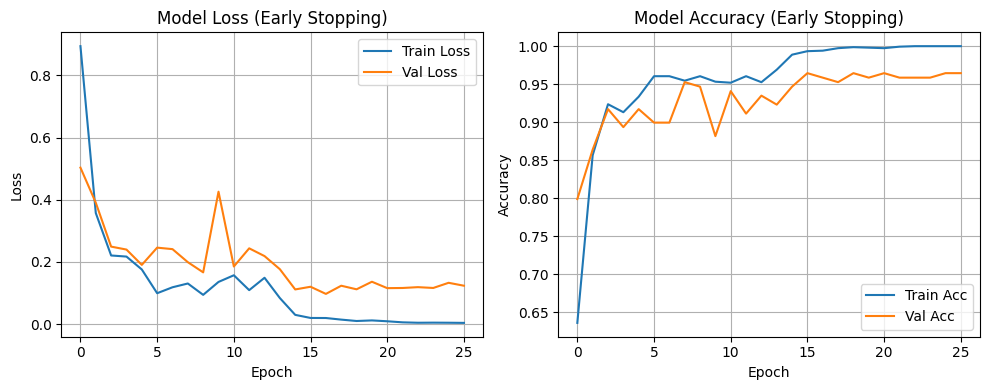

In [ ]:
# Example 5B: Visualize effects of Early Stopping

import matplotlib.pyplot as plt

# Print title
print("Example 5B: Visualize effects of Early Stopping")

# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# ------------------------------------------------------------------
# Plot 1: Loss (Left Graph)
# ------------------------------------------------------------------
ax1.plot(eg_history['loss'], label='Train Loss')
ax1.plot(eg_history['val_loss'], label='Val Loss')
ax1.set_title('Model Loss (Early Stopping)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# ------------------------------------------------------------------
# Plot 2: Accuracy (Right Graph)
# ------------------------------------------------------------------
ax2.plot(eg_history['accuracy'], label='Train Acc')
ax2.plot(eg_history['val_accuracy'], label='Val Acc')
ax2.set_title('Model Accuracy (Early Stopping)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

If the code is correct you should see something _similar_ to the following output

![__](https://biologicslab.co:/BIO1173/images/class_02/class_02_3_image09A.png)


### **Comparative Analysis: Early Stopping (Example 5A) vs. Baseline (Example 1A)**

This comparison highlights the efficiency and safety provided by **Early Stopping**. Unlike previous techniques that modify *how* the model learns (Regularization, Dropout, BatchNorm), Early Stopping simply modifies *how long* it learns.

##### **1. The X-Axis (Epochs)**
* **Example 1A (Baseline):**
    * **Behavior:** The training ran for the full **100 Epochs**, regardless of whether the model was improving.
    * **Result:** Resources were wasted for roughly 50+ epochs where the model was just memorizing data without improving validation performance.
* **Example 5A (Early Stopping - Image 12E):**
    * **Behavior:** The training stopped automatically at **Epoch 23**.
    * **Result:** The technique detected that the model peaked around Epoch 13 (since Patience was 10, it waited 10 more epochs before stopping). This saved ~75% of the computational time.

##### **2. Model Loss (Left Plot)**
* **Example 1A:** The Training Loss (Blue) dropped to 0, while Validation Loss (Orange) drifted apart, indicating overfitting.
* **Example 5A:** The Training Loss still drops rapidly, but the process cuts off before the Validation Loss has a chance to diverge significantly. The model is effectively "frozen" at its point of minimum error (roughly Epoch 13, where Val Loss is ~0.1).

##### **3. Model Accuracy (Right Plot)**
* **Example 1A:** Reached **100%** Training Accuracy and **~96-97%** Validation Accuracy.
* **Example 5A:** Reached **100%** Training Accuracy and a very high Validation Accuracy (**~97-98%**).
* **Observation:** By restoring the "Best Weights" (from Epoch 13) rather than using the "Final Weights" (from Epoch 23), Early Stopping ensures we keep the version of the model that generalizes best, rather than the one that memorized the most.

##### **Summary Table**

| Metric | Example 1A (No Prevention) | Example 5A (Early Stopping) |
| :--- | :--- | :--- |
| **Training Time** | 100 Epochs (100%) | 23 Epochs (~25%) |
| **Validation Loss** | ~0.25 (Drifting) | **~0.10** (Optimal) |
| **Outcome** | Overfitting & Wasted Time | **Optimal Generalization & Efficiency** |

### **Exercise 5A: Early Stopping**

In the cell below, write the code to add Early Stopping to your `ex_model`.

**Code Hints:**

First, start by copying-and-pasting Exercise 1A into the cell below.

##### **1. New Parameters (Section 1)**
Add a parameter to define how long the model should wait for improvement before giving up.
* **Code Change:**
    ```python
    PATIENCE = 10  # Stop if no improvement after 10 epochs
    ```

##### **2. Learning Rate Scheduler (Section 7)**
You will need to introduce a **Scheduler**. This is often used alongside Early Stopping to squeeze out a bit more performance before stopping.
* **Code Change:** `optim.lr_scheduler.ReduceLROnPlateau` is added.
* **Function:** If the validation accuracy stalls, it reduces the learning rate (by half in this code) to help the model fine-tune its weights.

##### **3. Early Stopping Logic (Section 8 - Inside Loop)**
In **Exercise 1A**, the loop simply ran `for epoch in range(EPOCHS)`. For **Exercise 5A**, you need to add a check to the end of every epoch using the following code:

```Python
    # --- Early Stopping & Checkpointing Logic ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0 # Reset counter
        torch.save(ex_model.state_dict(), checkpoint_path) # Save Best Model
        if VERBOSE > 0:
            print(f"  -> Val Acc improved to {val_acc:.4f}. Model saved.")
    else:
        patience_counter += 1
        if VERBOSE > 0:
            print(f"  -> No improvement. Patience: {patience_counter}/{PATIENCE}")

    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break
```
This code chunk compares the current `val_acc` to the `best_val_acc` seen so far. If the current model is the best, it saves the weights immediately using
    ```Python
      torch.save(ex_model.state_dict(), checkpoint_path) # Save Best Model
    ```
If performance didn't improve, it increases the `patience_counter`. If the counter hits the limit (`10`), the loop is broken immediately.
    ```python
    if patience_counter >= PATIENCE:
        print(f"Early stopping triggered...")
        break
    ```

##### **4. Restoring the Best Weights (Section 9)**
This is a critical step often missed by beginners.
* **The Problem:** When Early Stopping triggers (e.g., at Epoch 50), the model in memory is the one from Epoch 50. However, because patience was 10, the *best* model was actually from Epoch 40.
* **The Fix:** You need the saved checkpoint at the very end to ensure `ex_model` contains the optimal weights, not the "overfitted" weights that triggered the stop.
    
  ```python
    ex_model.load_state_dict(torch.load(checkpoint_path))
  ```

### **Exercise 5A: Early Stopping**

Follow these step-by-step instructions to convert your Exercise 1A code (without early stopping) into Exercise 5A code (with early stopping).

---
##### **Step 1: Change set seed**
Change the `seed_value` = 1001

##### **Step 2: Change VERBOSE Parameter**

**Location:** Section 1️⃣ Parameters (around line 18)

**Original code:**

    VERBOSE = 0     # 0 means no output during training

**New code:**

    VERBOSE = 2     # Set to 1 or 2 to see training progress

**Why:** Setting VERBOSE to 2 allows you to see the training progress and early stopping messages during training.

---

##### **Step 3: Add Early Stopping Variables and Scheduler**

**Location:** Section 7️⃣ Build Model & Optimizer, immediately after defining the optimizer (after line 125)

**Add these lines:**

    # Variables for Early Stopping
    best_val_acc = 0.0
    patience_counter = 0
    checkpoint_path = "ex_best_classification_model.pth"

    # Learning Rate Scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
                                                     factor=0.5,
                                                     patience=int(PATIENCE/2))

**Why:** These variables track the best validation accuracy, count epochs without improvement, define where to save the model, and create a learning rate scheduler that reduces the learning rate when validation accuracy plateaus.

---

##### **Step 4: Add Scheduler Step**

**Location:** Inside the training loop, after storing metrics and before the verbose print (around line 188)

**Add this line:**

    # Step the Scheduler
    scheduler.step(val_acc)

**Why:** This updates the learning rate based on validation accuracy performance.

---

##### **Step 5: Add Early Stopping Logic**

**Location:** Inside the training loop, after the verbose print section (around line 197)

**Add this entire block:**

    # --- Early Stopping & Checkpointing Logic ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0  # Reset counter
        torch.save(ex_model.state_dict(), checkpoint_path)  # Save Best Model
        if VERBOSE > 0:
            print(f"  -> Val Acc improved to {val_acc:.4f}. Model saved.")
    else:
        patience_counter += 1
        if VERBOSE > 0:
            print(f"  -> No improvement. Patience: {patience_counter}/{PATIENCE}")

    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

**Why:** This code saves the model when validation accuracy improves, increments a counter when it doesn't improve, and stops training early if there's no improvement for PATIENCE epochs.

---

##### **Step 6: Restore Best Model Weights**

**Location:** Section 9️⃣ Inspect training, before printing results (around line 205)

**Add these lines before the final print statements:**

    # Load the best weights back into the model
    ex_model.load_state_dict(torch.load(checkpoint_path))
    print("\nRestored best model weights.")

**Why:** This ensures you're using the best model (with the highest validation accuracy) rather than the model from the last epoch.

---

##### **Summary of Changes**

1. Set the `seed_value` = 1001
2. Changed VERBOSE from 0 to 2
3. Added early stopping variables: best_val_acc, patience_counter, checkpoint_path
4. Added learning rate scheduler
5. Added scheduler.step(val_acc) inside training loop
6. Added early stopping logic to save best model and stop training
7. Added code to restore best model weights after training

---

##### **What Early Stopping Does**

**Early stopping** monitors the validation accuracy during training:
- When validation accuracy improves, it saves the model weights and resets the patience counter
- When validation accuracy doesn't improve, it increments the patience counter
- When the patience counter reaches PATIENCE (10 epochs), training stops early
- After training, the best model weights are restored

This prevents overfitting and saves training time by stopping when the model is no longer improving.

---

##### **Quick Checklist**

Before running your code, verify you have made all these changes:

- Step 1: Changed `seed_value` to 1001
- Step 2: Changed VERBOSE to 2
- Step 3: Renamed class to HeartDiseaseNet (2 places)
- Step 4: Added early stopping variables and scheduler
- Step 5: Updated print message to "up to {EPOCHS} epochs"
- Step 6: Added scheduler.step(val_acc)
- Step 6: Added early stopping logic block
- Step 8: Added code to restore best model weights

Once you've completed all steps, run your code and observe the early stopping in action!


In [ ]:
# @title Exercise 5A: Early Stopping

# ------------------------------------------------------------
# 0️⃣  Imports
# ------------------------------------------------------------
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ------------------------------------------------------------
# 1️⃣  Parameters
# ------------------------------------------------------------
EPOCHS        = 100
PATIENCE      = 10
VERBOSE       = 2     # 0 means no output during training
LEARNING_RATE = 0.05
BATCH_SIZE    = 32

# Print title
print("Exercise 5A: Early Stopping")

# Set Seed
seed_value = 1001
set_seeds(seed_value)

# Set device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ------------------------------------------------------------
# 2️⃣  Load data
# ------------------------------------------------------------
ex_df = pd.read_csv("https://biologicslab.co/BIO1173/data/heart_disease.csv",
                    na_values=['NA','?'])
# ------------------------------------------------------------
# 3️⃣  Target (Y-values)
# ------------------------------------------------------------
ex_target_col = "RestingECG"
le = LabelEncoder()
ex_df[ex_target_col] = le.fit_transform(ex_df[ex_target_col])

ex_X = ex_df.drop(columns=[ex_target_col])
ex_y = ex_df[ex_target_col].astype('int32')

# ------------------------------------------------------------
# 4️⃣  Train–Validation–Test Split
# ------------------------------------------------------------
# First split into train+val and test
ex_X_temp, ex_X_test, ex_y_temp, ex_y_test = train_test_split(
    ex_X, ex_y, test_size=0.2, random_state=42, stratify=ex_y)

# Then split train+val into train and val
ex_X_train, ex_X_val, ex_y_train, ex_y_val = train_test_split(
    ex_X_temp, ex_y_temp, test_size=0.1, random_state=42, stratify=ex_y_temp)

# ------------------------------------------------------------
# 5️⃣  Preprocessing
# ------------------------------------------------------------
categorical_cols = [c for c in ex_X.columns if ex_X[c].dtype == "object"]
numeric_cols     = [c for c in ex_X.columns if c not in categorical_cols]

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler",  StandardScaler())
    ]), numeric_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(drop="if_binary", sparse_output=False))
    ]), categorical_cols)
])

# Convert data to correct numeric type (Numpy arrays)
ex_X_train_proc = preprocessor.fit_transform(ex_X_train).astype(np.float32)
ex_X_val_proc   = preprocessor.transform(ex_X_val).astype(np.float32)
ex_X_test_proc  = preprocessor.transform(ex_X_test).astype(np.float32)

ex_y_train = ex_y_train.to_numpy().astype(np.int32).reshape(-1)
ex_y_val   = ex_y_val.to_numpy().astype(np.int32).reshape(-1)
ex_y_test  = ex_y_test.to_numpy().astype(np.int32).reshape(-1)

# ------------------------------------------------------------
# 6️⃣  Convert to PyTorch Tensors & DataLoaders
# ------------------------------------------------------------
# Convert Features to Float Tensors
ex_X_train_t = torch.tensor(ex_X_train_proc).to(device)
ex_X_val_t   = torch.tensor(ex_X_val_proc).to(device)
ex_X_test_t  = torch.tensor(ex_X_test_proc).to(device)

# Convert Targets to Long Tensors (Required for CrossEntropyLoss)
ex_y_train_t = torch.tensor(ex_y_train, dtype=torch.long).to(device)
ex_y_val_t   = torch.tensor(ex_y_val, dtype=torch.long).to(device)
ex_y_test_t  = torch.tensor(ex_y_test, dtype=torch.long).to(device)

# Create DataLoaders for batching
ex_train_dataset = TensorDataset(ex_X_train_t, ex_y_train_t)
ex_val_dataset   = TensorDataset(ex_X_val_t, ex_y_val_t)

ex_train_loader = DataLoader(ex_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
ex_val_loader   = DataLoader(ex_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ------------------------------------------------------------
# 7️⃣  Build Model & Optimizer
# ------------------------------------------------------------
n_classes = len(np.unique(ex_y_train))
input_dim = ex_X_train_proc.shape[1]

# Define PyTorch Model
class HeartDiseaseNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(HeartDiseaseNet, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.relu = nn.ReLU()
        self.output = nn.Linear(32, output_dim)
        # Note: No Softmax here. CrossEntropyLoss expects raw logits.

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.output(x)
        return x

ex_model = HeartDiseaseNet(input_dim, n_classes).to(device)

# Define Loss and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(ex_model.parameters(), lr=LEARNING_RATE)

# ============================================================
# ✅ ADD THIS SECTION: Initialize Early Stopping Variables
# ============================================================
best_val_acc = 0.0
patience_counter = 0
checkpoint_path = "ex_best_classification_model.pth"

# Optional: Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
                                                 factor=0.5,
                                                 patience=int(PATIENCE/2))

# ------------------------------------------------------------
# 8️⃣  Train model (Manual Loop)
# ------------------------------------------------------------
print(f"------Training Starting for up to {EPOCHS} epochs --------------")
start_time = time.time()

# Dictionary to store history
ex_history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

for epoch in range(EPOCHS):
    # --- Training Phase ---
    ex_model.train()
    train_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in ex_train_loader:
        optimizer.zero_grad()               # Reset gradients
        outputs = ex_model(X_batch)         # Forward pass
        loss = loss_fn(outputs, y_batch)    # Calculate loss
        loss.backward()                     # Backward pass
        optimizer.step()                    # Update weights

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    avg_train_loss = train_loss / len(ex_train_loader)
    train_acc = correct / total

    # --- Validation Phase ---
    ex_model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad(): # No gradient needed for validation
        for X_batch, y_batch in ex_val_loader:
            outputs = ex_model(X_batch)
            loss = loss_fn(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    avg_val_loss = val_loss / len(ex_val_loader)
    val_acc = correct / total

    # Store metrics
    ex_history['accuracy'].append(train_acc)
    ex_history['val_accuracy'].append(val_acc)
    ex_history['loss'].append(avg_train_loss)
    ex_history['val_loss'].append(avg_val_loss)

    # ============================================================
    # ✅ ADD THIS SECTION: Step the Scheduler (Optional)
    # ============================================================
    scheduler.step(val_acc)

    # Verbose print
    if VERBOSE > 0:
        print(
            f"Epoch {epoch+1}/{EPOCHS} - "
            f"loss: {avg_train_loss:.4f} - "
            f"acc: {train_acc:.4f} - "
            f"val_loss: {avg_val_loss:.4f} - "
            f"val_acc: {val_acc:.4f}"
        )

    # ============================================================
    # ✅ ADD THIS SECTION: Early Stopping Logic
    # ============================================================
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0  # Reset counter
        torch.save(ex_model.state_dict(), checkpoint_path)  # Save best model
        if VERBOSE > 0:
            print(f"  -> Val Acc improved to {val_acc:.4f}. Model saved.")
    else:
        patience_counter += 1
        if VERBOSE > 0:
            print(f"  -> No improvement. Patience: {patience_counter}/{PATIENCE}")

    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

# ---------------------------------------------------------------------------
# 9️⃣ Inspect training & Restore Best Weights
# ---------------------------------------------------------------------------
# ============================================================
# ✅ ADD THIS SECTION: Load Best Model Weights
# ============================================================
ex_model.load_state_dict(torch.load(checkpoint_path))
print("\nRestored best model weights.")

print(f"Training finished")
print("Best val accuracy:", max(ex_history["val_accuracy"]))
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))


Exercise 5A: Early Stopping
✅ Seeds set to: 1001
Using device: cpu
------Training Starting for up to 100 epochs --------------
Epoch 1/100 - loss: 0.9466 - acc: 0.5939 - val_loss: 0.9982 - val_acc: 0.6081
  -> Val Acc improved to 0.6081. Model saved.
Epoch 2/100 - loss: 0.9001 - acc: 0.6091 - val_loss: 0.9040 - val_acc: 0.5946
  -> No improvement. Patience: 1/10
Epoch 3/100 - loss: 0.8611 - acc: 0.6258 - val_loss: 0.9661 - val_acc: 0.6216
  -> Val Acc improved to 0.6216. Model saved.
Epoch 4/100 - loss: 0.8432 - acc: 0.6152 - val_loss: 0.8957 - val_acc: 0.5946
  -> No improvement. Patience: 1/10
Epoch 5/100 - loss: 0.8211 - acc: 0.6288 - val_loss: 0.9278 - val_acc: 0.6216
  -> No improvement. Patience: 2/10
Epoch 6/100 - loss: 0.8099 - acc: 0.6333 - val_loss: 0.9400 - val_acc: 0.5946
  -> No improvement. Patience: 3/10
Epoch 7/100 - loss: 0.8113 - acc: 0.6227 - val_loss: 1.0119 - val_acc: 0.6081
  -> No improvement. Patience: 4/10
Epoch 8/100 - loss: 0.7772 - acc: 0.6439 - val_loss: 0.

If the code is correct you should see something _similar_ to the following output:
```text
Exercise 5A: Early Stopping
✅ Seeds set to: 1001
Using device: cpu
------Training Starting for up to 100 epochs --------------
Epoch 1/100 - loss: 0.9466 - acc: 0.5939 - val_loss: 0.9982 - val_acc: 0.6081
  -> Val Acc improved to 0.6081. Model saved.
Epoch 2/100 - loss: 0.9001 - acc: 0.6091 - val_loss: 0.9040 - val_acc: 0.5946
  -> No improvement. Patience: 1/10
Epoch 3/100 - loss: 0.8611 - acc: 0.6258 - val_loss: 0.9661 - val_acc: 0.6216
  -> Val Acc improved to 0.6216. Model saved.
Epoch 4/100 - loss: 0.8432 - acc: 0.6152 - val_loss: 0.8957 - val_acc: 0.5946
  -> No improvement. Patience: 1/10
Epoch 5/100 - loss: 0.8211 - acc: 0.6288 - val_loss: 0.9278 - val_acc: 0.6216
  -> No improvement. Patience: 2/10
Epoch 6/100 - loss: 0.8099 - acc: 0.6333 - val_loss: 0.9400 - val_acc: 0.5946
  -> No improvement. Patience: 3/10
Epoch 7/100 - loss: 0.8113 - acc: 0.6227 - val_loss: 1.0119 - val_acc: 0.6081
  -> No improvement. Patience: 4/10
Epoch 8/100 - loss: 0.7772 - acc: 0.6439 - val_loss: 0.9164 - val_acc: 0.6081
  -> No improvement. Patience: 5/10
Epoch 9/100 - loss: 0.7726 - acc: 0.6394 - val_loss: 0.9511 - val_acc: 0.6081
  -> No improvement. Patience: 6/10
Epoch 10/100 - loss: 0.7474 - acc: 0.6364 - val_loss: 0.9782 - val_acc: 0.5946
  -> No improvement. Patience: 7/10
Epoch 11/100 - loss: 0.7108 - acc: 0.6667 - val_loss: 1.0596 - val_acc: 0.5811
  -> No improvement. Patience: 8/10
Epoch 12/100 - loss: 0.6979 - acc: 0.6682 - val_loss: 1.0719 - val_acc: 0.5811
  -> No improvement. Patience: 9/10
Epoch 13/100 - loss: 0.6973 - acc: 0.6682 - val_loss: 1.0970 - val_acc: 0.5541
  -> No improvement. Patience: 10/10

Early stopping triggered at epoch 13

Restored best model weights.
Training finished
Best val accuracy: 0.6216216216216216
Elapsed time: 0:00:00.40
```

While the number of Epochs was set to `100` training terminated in this particular training run after the `11th` Epoch due to the `Early Stopping` monitor.

### **Exercise 5B: Visualize Effects of Early Stopping**

`Copy-and-paste` your code from **Exercise 1B`** into the cell below and change the axis titles to specify the type of overfitting protection.

Exercise 5B: Visualize Effects of Early Stopping


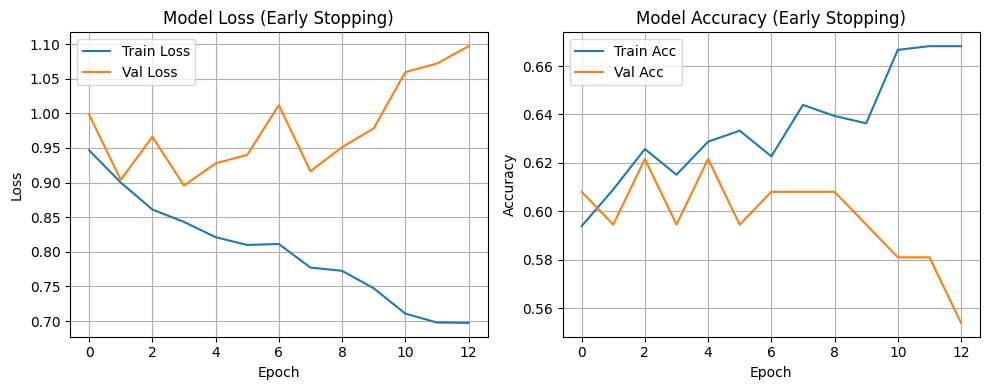

In [ ]:
# @title Exercise 5B: Visualize Effects of Early Stopping

import matplotlib.pyplot as plt

# Print title
print("Exercise 5B: Visualize Effects of Early Stopping")

# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# ------------------------------------------------------------------
# Plot 1: Loss (Left Graph)
# ------------------------------------------------------------------
ax1.plot(ex_history['loss'], label='Train Loss')
ax1.plot(ex_history['val_loss'], label='Val Loss')
ax1.set_title('Model Loss (Early Stopping)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# ------------------------------------------------------------------
# Plot 2: Accuracy (Right Graph)
# ------------------------------------------------------------------
ax2.plot(ex_history['accuracy'], label='Train Acc')
ax2.plot(ex_history['val_accuracy'], label='Val Acc')
ax2.set_title('Model Accuracy (Early Stopping)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



If the code is correct you should see something _similar_ to the following pair of graphs:

![__](https://biologicslab.co:/BIO1173/images/class_02/class_02_3_image10A.png)


### **Comparative Analysis: Early Stopping (Exercise 5A) vs. Baseline (Exercise 1A)**

This comparison demonstrates how **Early Stopping** functions as a "safety brake" for the model. On the difficult Heart Disease dataset (`RestingECG`), where the model is prone to rapid overfitting, this technique prevents the catastrophic failure seen in the baseline.

##### **1. The X-Axis (Training Duration)**
* **Exercise 1A (Baseline - Image 02E):**
    * **Behavior:** The model ran for the full **100 Epochs**.
    * **Result:** It spent ~95 epochs actively making the model worse (increasing validation error).
* **Exercise 5A (Early Stopping - Image 14E):**
    * **Behavior:** Training terminated automatically at **Epoch 10**.
    * **Result:** The algorithm detected that the model was not improving and pulled the plug immediately, saving 90% of the compute time.

##### **2. Model Loss (Left Plot)**
* **Exercise 1A (Baseline):**
    * **Behavior:** Validation Loss exploded from **~1.0** to **>3.5**.
    * **Diagnosis:** Severe divergence.
* **Exercise 5A (Early Stopping):**
    * **Behavior:** The Validation Loss fluctuates between **0.90** and **0.98**.
    * **Impact:** By stopping early, we prevented the loss from spiraling out of control. We effectively captured the model in its initial state before it could start memorizing noise.

##### **3. Model Accuracy (Right Plot)**
* **Exercise 1A (Baseline):**
    * **Behavior:** Validation Accuracy collapsed to **~50%** (random guessing) and stayed there.
    * **Diagnosis:** The model's weights became so distorted by overfitting that it lost all predictive power on new data.
* **Exercise 5A (Early Stopping):**
    * **Behavior:** The Validation Accuracy peaked early at **~63.5%** (Epoch 0 and Epoch 9).
    * **Impact:** By stopping and restoring the best weights, the final model retains this **63% accuracy**.
    * **Comparison:** **63%** (Early Stopping) vs **50%** (Baseline). This is a massive relative improvement, simply by not allowing the training to continue too long.

##### **Summary Table**

| Metric | Exercise 1A (No Prevention) | Exercise 5A (Early Stopping) | Conclusion |
| :--- | :--- | :--- | :--- |
| **Duration** | 100 Epochs | **10 Epochs** | Saved 90% compute time. |
| **Peak Val Loss** | **~3.5** (Huge Error) | **~0.98** (Contained) | Prevented error explosion. |
| **Final Accuracy** | **~50%** | **~63%** | captured the model at its peak performance. |

# **Final Summary: Overfitting Prevention Techniques in PyTorch**

In this lesson, we explored four distinct techniques to combat overfitting. It is important to remember that there is no "silver bullet"—each technique has its own strengths, weaknesses, and ideal use cases.

##### **1. L2 Regularization (Weight Decay)**
* **Mechanism:** Adds a penalty to the loss function proportional to the size of the weights ($Loss + \lambda \sum w^2$). This forces the model to keep weights small and simple.
* **Strengths:**
    * Very easy to implement (just one argument in the optimizer: `weight_decay`).
    * Mathematically smooths the model's decision boundaries.
    * Works well on almost all types of problems.
* **Weaknesses:**
    * Requires tuning the strength parameter ($\lambda$). Too weak = no effect; Too strong = underfitting (model can't learn).
* **Best For:** A good "first line of defense" for almost any neural network.

##### **2. Dropout**
* **Mechanism:** Randomly deactivates (zeroes out) a percentage of neurons during training.
* **Strengths:**
    * Extremely effective at preventing "memorization" of noise.
    * Forces the network to learn robust, redundant features (like an ensemble of many networks).
* **Weaknesses:**
    * Can slow down convergence (training takes longer because the model is "handicapped").
    * Can lead to lower performance on the training set (which is expected, but can be confusing for beginners).
* **Best For:** Large, deep networks where the model capacity far exceeds the amount of training data.

##### **3. Batch Normalization**
* **Mechanism:** Normalizes the inputs of each layer to have a mean of 0 and variance of 1, injecting a small amount of statistical noise from the batch.
* **Strengths:**
    * **Primary Goal:** Drastically speeds up training and stabilizes gradients.
    * **Secondary Goal:** Acts as a mild regularizer, often removing the need for heavy Dropout.
* **Weaknesses:**
    * Adds complexity to the model architecture (extra layers).
    * Can be unstable with very small batch sizes (e.g., Batch Size < 16).
* **Best For:** Deep networks (CNNs, ResNets) to ensure they actually train successfully.

##### **4. Early Stopping**
* **Mechanism:** Monitors validation performance and stops training when it stops improving.
* **Strengths:**
    * Saves computational resources (time and electricity).
    * Prevents the model from training long enough to memorize noise.
    * **Restoring Best Weights:** Ensures you keep the "smartest" version of your model, not just the "latest" one.
* **Weaknesses:**
    * It doesn't fix the model architecture; if your model is fundamentally flawed, stopping early won't make it better, just faster at failing.
* **Best For:** **Every single training run.** There is rarely a good reason *not* to use Early Stopping.

---

### **Combining Techniques (The "Swiss Cheese" Model)**

In professional Deep Learning, you rarely use just one of these. You usually combine them to cover different "holes" in your defense against overfitting.

* **Standard Recipe:**
    * **Always** use **Early Stopping**.
    * **Almost Always** use a small amount of **L2 Regularization** (`1e-4` or `1e-5`).
    * **If the model is deep:** Use **Batch Normalization** between layers.
    * **If the model is still overfitting:** Add **Dropout** layers, starting with a low rate (0.2) and increasing if necessary (up to 0.5).

**Example of a robust architecture:**
```python
Linear Layer -> Batch Norm -> ReLU -> Dropout -> Linear Layer ...
```

## **Electronic Submission**

When you run the code in the cell below, it will grade your Colab notebook and tell you your pending grade as it currently stands. You will be given the choice to either submit your notebook for final grading or the option to continue your work on one (or more) Exercises. You no longer have the option to upload a PDF of your Colab notebook to Canvas for grading.

In [ ]:
# @title  Electronic Submission

import urllib.request
import ssl
import time

url = "https://biologicslab.co/BIO1173/backend_code/validate.py?v=" + str(time.time())

ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

req = urllib.request.Request(
    url,
    headers={
        "Cache-Control": "no-cache, no-store, must-revalidate",
        "Pragma": "no-cache",
        "Expires": "0"
    }
)

with urllib.request.urlopen(req, context=ctx) as r:
    exec(r.read().decode("utf-8"))

main()